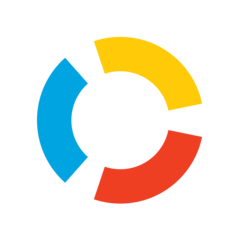

<h1 style="text-align:center;font-size:30px;" > Elo Merchant Category Recommendation </h1>

<h1>1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p> Elo, one of the largest payment brands in Brazil, has tied up with various merchants and offers discounts and promotions to car holders. The company wants to find out whether these recommendations are useful to customers or not. The company wants to predict a score called Loyalty Score for every card holder, based on various transactions data. This score represents how much the customers are enjoying the recommendations and how useful it is to them.This loyalty score will help Elo to focus on specific customers, thus reducing the unwanted costs that Elo spends on promotions. 

This is a Kaggle problem. (https://www.kaggle.com/c/elo-merchant-category-recommendation)
</p>

<h2> 1.2 Problem Statement </h2>

<p> Predict a score called loyalty score for every card id based on various transactional data. </p>

<h2> 1.3 Sources </h2>



*   Source : https://www.kaggle.com/c/elo-merchant-category-recommendation
*   



<h2>1.4 Real world/Business Objectives and Constraints </h2>



*   Predict a score given a card id.
*   Minimize the the difference between the actual and predicted scores (RMSE).
*   No latency concerns.



<h1>2. Machine Learning Problem </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

<p> 
- Data is present in 5 files namely <br>


*   train.csv
*   test.csv
*   merchants.csv
*   transactions.csv
*   new_merchants_transactions.csv
</p>

<h2>2.2 Mapping the real world problem to a Machine Learning Problem </h2>

<h3> 2.2.1 Type of Machine Learning Problem </h3>

<p> It is a regression problem, where we have to predict loyalty score for a given card id. </p>

<h3> 2.2.2 Performance Metric </h3>

Source:  https://www.kaggle.com/c/elo-merchant-category-recommendation

Metric: 
* RMSE - Root Mean Square Error: https://en.wikipedia.org/wiki/Root-mean-square_deviation

  - We could have gone for other metric like MAD. But as we know these metric reduces the affect the outliers. But our dataset contains outliers and also the test data contains these outliers. So we want our better fit to these outliers as well.

<h3> 2.2.3 Necessary Imports </h3>

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
gc.collect()
from tqdm import tqdm

<h1>3. Exploratory Data Analysis </h1>

In [2]:
#https://www.kaggle.com/artgor/elo-eda-and-models
def reduce_mem_usage(df, verbose=True):
    ''' 
    This is done as there are lot of historical data, which requires lot of RAM. 
    This method  tries to reduce the size of data, it works on only numeric data by selecting the smallest data type
    in which it can be represented.
    '''
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df 


<h2> 3.1 Reading data from files train.csv and test.cv and basic stats </h2>

In [ ]:
df_train = reduce_mem_usage(pd.read_csv("train.csv", parse_dates=['first_active_month']))
print("No. of data points in train:", df_train.shape[0])

Mem. usage decreased to  4.04 Mb (56.2% reduction)
No. of data points in train: 201917


In [ ]:
df_train.sort_values(by = 'first_active_month', inplace=True)

In [ ]:
df_train.head(5)

,first_active_month,card_id,feature_1,feature_2,feature_3,target
69678,2011-11-01,C_ID_f25b3d3f13,3,1,1,0.645996
145874,2011-11-01,C_ID_2dbbc2b7fd,3,3,1,-0.069580
9322,2011-11-01,C_ID_0a70866829,3,1,1,-2.544922
33398,2011-11-01,C_ID_08cb8e0333,3,3,1,-3.574219
152463,2011-11-01,C_ID_d26de4d1bf,3,3,1,-0.693359


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201917 entries, 69678 to 43740
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   first_active_month  201917 non-null  datetime64[ns]
 1   card_id             201917 non-null  object        
 2   feature_1           201917 non-null  int8          
 3   feature_2           201917 non-null  int8          
 4   feature_3           201917 non-null  int8          
 5   target              201917 non-null  float16       
dtypes: datetime64[ns](1), float16(1), int8(3), object(1)
memory usage: 5.6+ MB


In [ ]:
df_test = reduce_mem_usage(pd.read_csv("test.csv", parse_dates=['first_active_month']))
print("No. of data points in test.csv:", df_test.shape[0])

Mem. usage decreased to  2.24 Mb (52.5% reduction)
No. of data points in test.csv: 123623


In [ ]:
df_test.head(5)

,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04-01,C_ID_0ab67a22ab,3,3,1
1,2017-01-01,C_ID_130fd0cbdd,2,3,0
2,2017-08-01,C_ID_b709037bc5,5,1,1
3,2017-12-01,C_ID_d27d835a9f,2,1,0
4,2015-12-01,C_ID_2b5e3df5c2,5,1,1


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123623 entries, 0 to 123622
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   first_active_month  123622 non-null  datetime64[ns]
 1   card_id             123623 non-null  object        
 2   feature_1           123623 non-null  int8          
 3   feature_2           123623 non-null  int8          
 4   feature_3           123623 non-null  int8          
dtypes: datetime64[ns](1), int8(3), object(1)
memory usage: 2.2+ MB


<h3> 3.1.1 Checking if there are any null values and replacing them </h3>

In [ ]:
nan_indexes = df_train[df_train.isnull().any(1)]
print (nan_indexes)

Empty DataFrame
Columns: [first_active_month, card_id, feature_1, feature_2, feature_3, target]
Index: []




*   There are no NaN values in train.csv


In [ ]:
nan_indexes = df_test[df_test.isnull().any(1)]
print (nan_indexes)

      first_active_month          card_id  feature_1  feature_2  feature_3
11578                NaT  C_ID_c27b4f80f7          5          2          1




*   There is one NaN value in test.csv in the field first_active_month.


*   We will replace this value by selecting all the rows having same features(feature_1, feature_2, feature_3) as this row and then select the mode of first_active_month from these rows.



In [ ]:
mode_Date = df_test.loc[(df_test['feature_1'] == 5) & (df_test['feature_2'] == 2) & (df_test['feature_3'] == 1)]['first_active_month'].mode().values[0]
print("Date occuring maximum no of times with these features ", mode_Date)
df_test['first_active_month'] = df_test["first_active_month"].fillna(mode_Date)

Date occuring maximum no of times with these features  2017-01-01T00:00:00.000000000


<h3> 3.1.2 Checking if there is any correlation between first_active_month and target </h3>

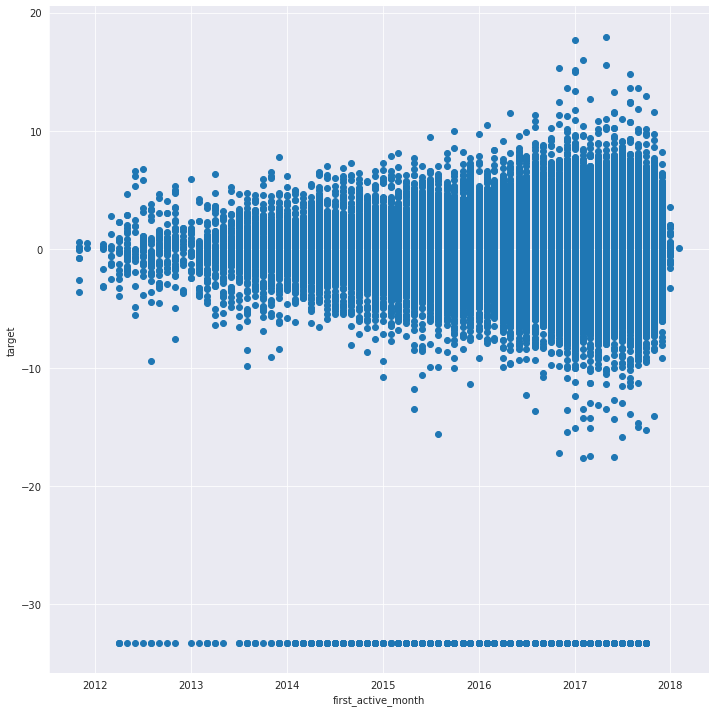

In [ ]:
sns.set_style("darkgrid")
sns.FacetGrid(df_train, size = 10)\
    .map(plt.scatter, 'first_active_month', 'target')\
    .add_legend()
plt.show()



*   One thing that can be clearly observed that dates which are more recent have higher loyalty score.
* Also it shows that more no of users have started using the Elo service lately.
* This feature clearly indicates a trend in loyalty score. 
* Also there seems a constant value which is present below -30, which can't be separated using first_active_month.

<h3> 3.1.3 Checking if there is any correlation between features - feature_1, feature_2, feature_3 and target </h3>

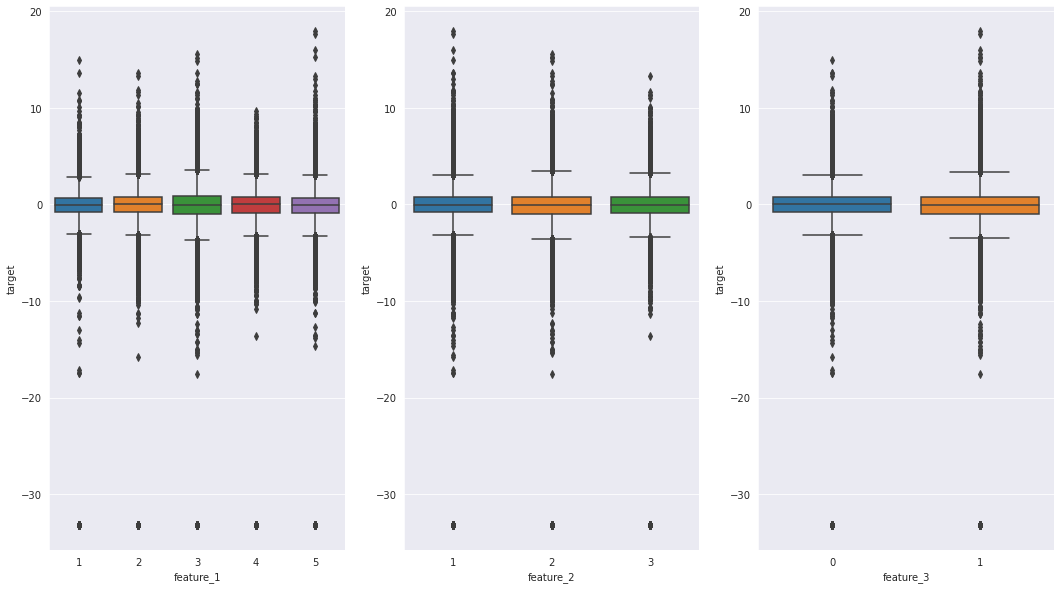

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (18,10))
sns.boxplot( x = 'feature_1', y= 'target', ax = ax[0], data = df_train)
sns.boxplot( x = 'feature_2', y= 'target', ax = ax[1], data = df_train)
sns.boxplot( x = 'feature_3', y= 'target', ax = ax[2], data = df_train)
plt.show()



*   These categorical features aren't really helpful at predicting the target variable. 
* The boxplots are overlapping for all the categories. 
*  We can ignore these features.



<h3> 3.1.4 Analysis of how these categorical variables are related with the target score </h3>

- We are concating all the categorical variables and plotting them against the target score.

In [ ]:
concatOfAllTrainPoints = []
allTargetPoints = []
for i, row in df_train.iterrows():
    f = str(row['feature_1']) + str(row['feature_2']) + str(row['feature_3'])
    concatOfAllTrainPoints.append(f)
    allTargetPoints.append(row['target'])

In [ ]:
data = {'Concat_Of_All_Features': concatOfAllTrainPoints, 
        'Loyalty_Scores': allTargetPoints}
data = pd.DataFrame(data)

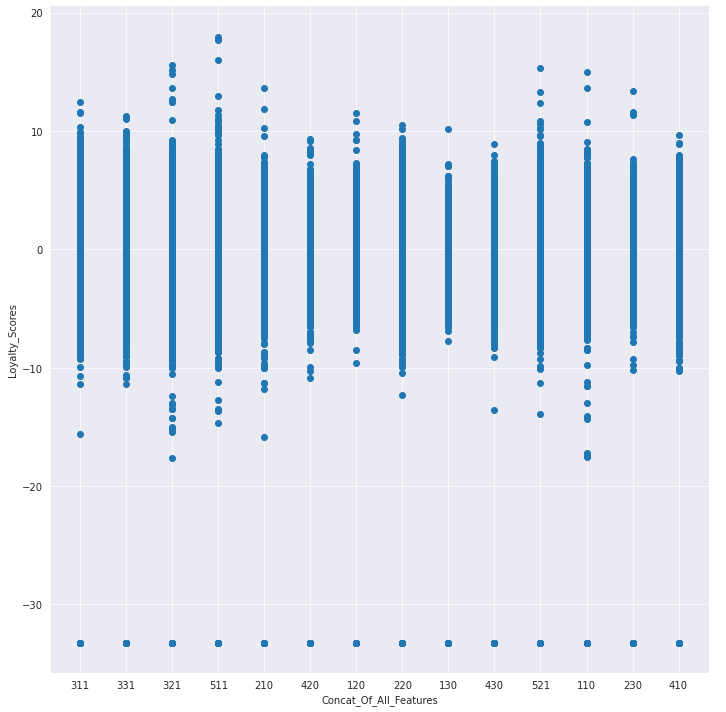

In [ ]:
sns.FacetGrid(data, size = 10)\
    .map(plt.scatter, 'Concat_Of_All_Features', 'Loyalty_Scores')\
    .add_legend()
plt.show()

- Nothing much be derived from these multivariate analysis. As points seem to be evenly distributed among all the categories.

<h3> 3.1.5 Analysis on the target variable(loyalty score) </h3>

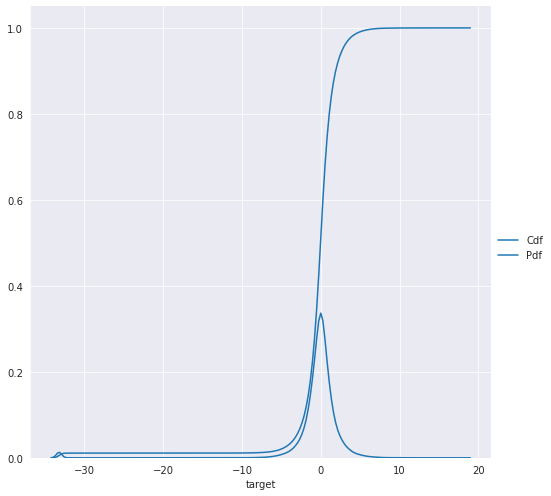

In [ ]:
sns.FacetGrid(df_train, size = 7)\
    .map(sns.distplot, 'target', hist=False, kde_kws=dict(cumulative=True), label = 'Cdf')\
    .map(sns.distplot, 'target', hist=False, label = 'Pdf')\
    .add_legend()
plt.show()

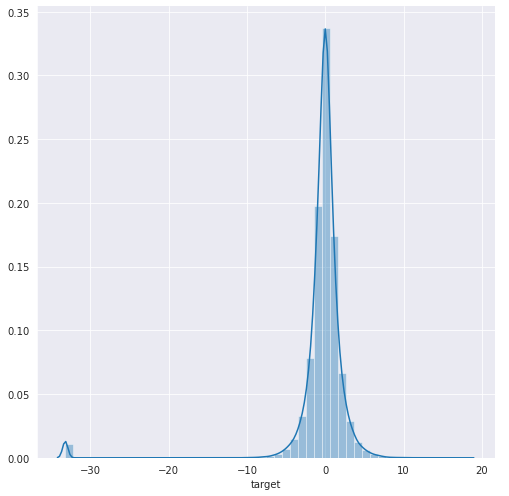

In [ ]:
sns.FacetGrid(df_train, size = 7)\
    .map(sns.distplot, 'target')\
    .add_legend()
plt.show()



*   Most of the data is centered around zero.
*   There exists some scores which have values in the range of -30.
*   We need to deal with card ids having score less than -30. We will see what can be used to differentiate these cards from other cards.



In [ ]:
print("No of values less than -10 : ", df_train.loc[df_train.target < -10].shape[0])
print("No of values less than -20 : ", df_train.loc[df_train.target < -20].shape[0])
print("No of values less than -30 : ", df_train.loc[df_train.target < -30].shape[0])
print("No of values less than -31 : ", df_train.loc[df_train.target < -31].shape[0])
print("No of values less than -32 : ", df_train.loc[df_train.target < -32].shape[0])
print("No of values less than -33 : ", df_train.loc[df_train.target < -33].shape[0])
print("No of values less than -34 : ", df_train.loc[df_train.target < -34].shape[0])

No of values less than -10 :  2263
No of values less than -20 :  2207
No of values less than -30 :  2207
No of values less than -31 :  2207
No of values less than -32 :  2207
No of values less than -33 :  2207
No of values less than -34 :  0




*   There are more than 2000 points that are between -10 and -34(excluded).
*   We can look to ignore these outliers, but we will wait to see whether these points affect our submissions.



In [ ]:
df_train.to_csv("train_EDA.csv", index = False)
df_test.to_csv("test_EDA.csv", index = False)

<h2> 3.2 Reading data from files transactions.csv and new_merchant_transactions.csv and basic stats </h2>

In [ ]:
df_histTrans = reduce_mem_usage(pd.read_csv("historical_transactions.csv", parse_dates=['purchase_date']))
print("No. of data points in historical_transactions:", df_histTrans.shape[0])

Mem. usage decreased to 1749.11 Mb (43.7% reduction)
No. of data points in historical_transactions: 29112361


In [ ]:
df_histTrans.head(5)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [ ]:
df_histTrans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29112361 entries, 0 to 29112360
Data columns (total 14 columns):
 #   Column                Dtype         
---  ------                -----         
 0   authorized_flag       object        
 1   card_id               object        
 2   city_id               int16         
 3   category_1            object        
 4   installments          int16         
 5   category_3            object        
 6   merchant_category_id  int16         
 7   merchant_id           object        
 8   month_lag             int8          
 9   purchase_amount       float32       
 10  purchase_date         datetime64[ns]
 11  category_2            float16       
 12  state_id              int8          
 13  subsector_id          int8          
dtypes: datetime64[ns](1), float16(1), float32(1), int16(3), int8(3), object(5)
memory usage: 1.7+ GB


In [ ]:
df_newTrans = reduce_mem_usage(pd.read_csv("new_merchant_transactions.csv", parse_dates=['purchase_date']))
print("No. of data points in new_merchant_transactions:", df_newTrans.shape[0])

Mem. usage decreased to 114.20 Mb (45.5% reduction)
No. of data points in new_merchant_transactions: 1963031


In [ ]:
df_newTrans.head(5)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557617,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569336,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551270,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671875,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659668,2018-03-22 21:07:53,NaN,-1,29


In [ ]:
df_newTrans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1963031 entries, 0 to 1963030
Data columns (total 14 columns):
 #   Column                Dtype         
---  ------                -----         
 0   authorized_flag       object        
 1   card_id               object        
 2   city_id               int16         
 3   category_1            object        
 4   installments          int16         
 5   category_3            object        
 6   merchant_category_id  int16         
 7   merchant_id           object        
 8   month_lag             int8          
 9   purchase_amount       float16       
 10  purchase_date         datetime64[ns]
 11  category_2            float16       
 12  state_id              int8          
 13  subsector_id          int8          
dtypes: datetime64[ns](1), float16(2), int16(3), int8(3), object(5)
memory usage: 114.2+ MB


<h3> 3.2.1 Checking if there are any null values and replacing them </h3>

In [ ]:
#https://stackoverflow.com/questions/36226083/how-to-find-which-columns-contain-any-nan-value-in-pandas-dataframe
print("Columns having null values in historical_transactions", df_histTrans.columns[df_histTrans.isnull().any()].tolist())

Columns having null values in historical_transactions ['category_3', 'merchant_id', 'category_2']


In [ ]:
print("Percentage of values rows having the null values")
print((df_histTrans[df_histTrans.columns[df_histTrans.isnull().any()].tolist()].isnull().sum()/df_histTrans.shape[0])*100)

Percentage of values rows having the null values
category_3     0.611970
merchant_id    0.475678
category_2     9.112500
dtype: float64


*   Columns category_3 and and merchant_id have very low % of missing values, whereas category_2 have 9% missing rows.
*   Since category_2 have lot of missing values we can introduce a new value for this missing values.
*   Rest of the missing rows can be filled with the modes since only a few % have them missing.


In [ ]:
mode_C3 = df_histTrans['category_3'].mode().values[0]
print("Mode of Category 3:", mode_C3)
df_histTrans['category_3'] = df_histTrans["category_3"].fillna(mode_C3)

Mode of Category 3: A


In [ ]:
df_histTrans['category_2'].value_counts()

1.0    15177199
3.0     3911795
5.0     3725915
4.0     2618053
2.0     1026535
Name: category_2, dtype: int64

In [ ]:
# New category for the missing values
unknown  = 6.0
df_histTrans['category_2'] = df_histTrans["category_2"].fillna(unknown)

In [ ]:
mode_merchantid = df_histTrans['merchant_id'].mode().values[0]
print("Mode of merchant_id:", mode_merchantid)
df_histTrans['merchant_id'] = df_histTrans["merchant_id"].fillna(mode_merchantid)

Mode of merchant_id: M_ID_00a6ca8a8a


In [ ]:
print("Columns having null values in new_merchant_transactions", df_newTrans.columns[df_newTrans.isnull().any()].tolist())

Columns having null values in new_merchant_transactions ['category_3', 'merchant_id', 'category_2']


In [ ]:
print("Percentage of values rows having the null values")
print((df_newTrans[df_newTrans.columns[df_newTrans.isnull().any()].tolist()].isnull().sum()/df_newTrans.shape[0])*100)

Percentage of values rows having the null values
category_3     2.848758
merchant_id    1.335486
category_2     5.692473
dtype: float64


*  There is a very small % of missing rows for category_3 and merchant_id. We can replace these values with their modes.
*  However for category_2 we will use the new category that we used above.

In [ ]:
mode_C3 = df_newTrans['category_3'].mode().values[0]
print("Mode of Category 3:", mode_C3)
df_newTrans['category_3'] = df_newTrans["category_3"].fillna(mode_C3)

Mode of Category 3: A


In [ ]:
df_newTrans['category_2'] = df_newTrans["category_2"].fillna(unknown)

In [ ]:
mode_merchantid = df_newTrans['merchant_id'].mode().values[0]
print("Mode of merchant_id:", mode_merchantid)
df_newTrans['merchant_id'] = df_newTrans["merchant_id"].fillna(mode_merchantid)

Mode of merchant_id: M_ID_00a6ca8a8a


<h3> 3.2.2 Analysis on authorized flag </h3>

In [ ]:
df_histTrans['authorized_flag'] = df_histTrans['authorized_flag'].apply(lambda x : 1 if x == 'Y' else 0)
df_newTrans['authorized_flag'] = df_newTrans['authorized_flag'].apply(lambda x : 1 if x == 'Y' else 0)

In [ ]:
df_newTrans['authorized_flag'].value_counts()

1    1963031
Name: authorized_flag, dtype: int64

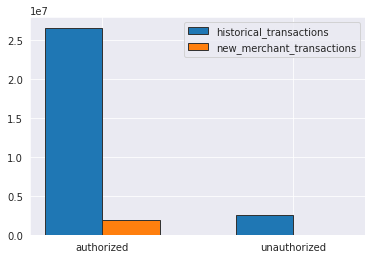

In [ ]:
x = np.array(['authorized', 'unauthorized'])
plt.bar(x, [df_histTrans['authorized_flag'].value_counts().values[0], df_histTrans['authorized_flag'].value_counts().values[1]], width=-0.3, align='edge', label='historical_transactions', edgecolor=[0.2]*3)
plt.bar(x, [df_newTrans['authorized_flag'].value_counts().values[0], 0], width=0.3, align='edge', label='new_merchant_transactions', edgecolor=[0.2]*3)
plt.legend()
plt.show()



*   There are some transactions in historical_transactions which are not authorized. We can combine these transactions with their respective card_id and see what are their loyalty scores.
*   We don't have any unauthorized transactions in new_merchant_transactions,we can drop this column from new_merchant_transactions as all the values are same.



<h4> 3.2.2.1 Analysis on loyalty scores of card ids who have done unauthorized, authorized transactions transactions </h4>

In [ ]:
cardids_UnAuth = list(set(df_histTrans.loc[df_histTrans['authorized_flag'] == 0]['card_id']))

In [ ]:
#https://stackoverflow.com/questions/12096252/use-a-list-of-values-to-select-rows-from-a-pandas-dataframe
loyalty_Scores_UnAuth = df_train[df_train['card_id'].isin(cardids_UnAuth)]['target']

In [ ]:
cardids_Auth = list(set(df_histTrans.loc[df_histTrans['authorized_flag'] == 1]['card_id']))

In [ ]:
loyalty_Scores_Auth = df_train[df_train['card_id'].isin(cardids_UnAuth)]['target']

In [ ]:
data = {'Auth_Data' : loyalty_Scores_Auth,
        'UnAuth_Data' : loyalty_Scores_UnAuth
}
data = pd.DataFrame(data)

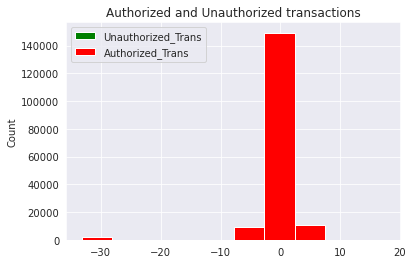

In [ ]:
plt.hist(loyalty_Scores_UnAuth, color='g', label='Unauthorized_Trans')
plt.hist(loyalty_Scores_Auth, color='r', label='Authorized_Trans')
plt.gca().set(title='Authorized and Unauthorized transactions', ylabel='Count')
plt.legend();



*   This seems to be evenly distributed not much can be deduced from these loyalty scores.
* The distributions are both similar so the latter overshadows the former.
*   Unauthorized transactions aren't really affecting the loyalty score.
*   They can be due to some error in network or other reasons.



<h3> 3.2.3 Analysis on categorical features </h3>

<h4> 3.2.3.1 City Id </h4>

In [ ]:
cityids = list(set(df_histTrans['city_id']))
cityids.extend(list(set(df_newTrans['city_id'])))
print("No. of unique city ids", len(list(set(cityids))))

No. of unique city ids 308


- Seeing whether these feature will be useful or not. We will group all the card ids by the installments and take average of the loyalty score by the installments. .

In [ ]:
groupedCardIds = df_histTrans.groupby('city_id')['card_id'].apply(list)

In [ ]:
listOfLoyaltyScores = []
for i in range(308):
    listOfAllUniqueIds = list(set(groupedCardIds.values[i]))
    sumOfLoyaltyScores = np.sum(df_train[df_train['card_id'].isin(listOfAllUniqueIds)]['target'])
    listOfLoyaltyScores.append(sumOfLoyaltyScores)

In [ ]:
data = {'City_Ids': list(groupedCardIds.keys()), 
        'Mean_Loyalty_Scores': listOfLoyaltyScores}
data = pd.DataFrame(data)

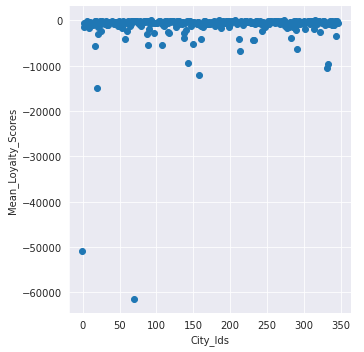

In [ ]:
sns.FacetGrid(data, size = 5)\
    .map(plt.scatter, 'City_Ids', 'Mean_Loyalty_Scores')\
    .add_legend()
plt.show()

- There is no such trend that can be seen. We can ignore these features.

<h4> 3.2.3.2  State Id </h4>

In [ ]:
stateids = list(set(df_histTrans['state_id']))
stateids.extend(list(set(df_newTrans['state_id'])))
print("No. of unique state ids", len(list(set(stateids))))

No. of unique state ids 25


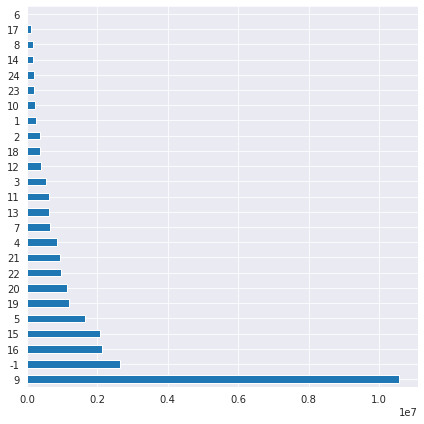

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (7,7))
df_histTrans['state_id'].value_counts().plot(kind = 'barh')
plt.show()

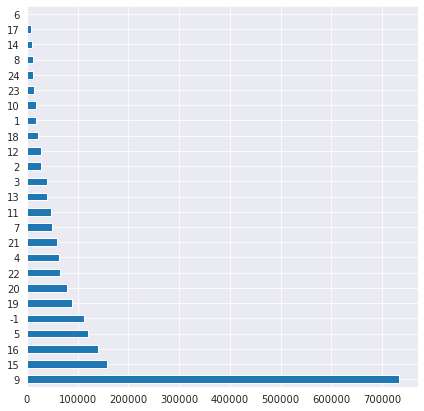

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (7,7))
df_newTrans['state_id'].value_counts().plot(kind = 'barh')
plt.show()

- State 9 is most occuring 

<h4> 3.2.3.3 Analysis on both city_id and state_id </h4>

In [ ]:
groupedCardIds = df_histTrans.groupby(['city_id', 'state_id'])['card_id'].apply(list)

In [ ]:
listOfLoyaltyScores = []
for i in range(len(groupedCardIds)):
    listOfAllUniqueIds = list(set(groupedCardIds.values[i]))
    sumOfLoyaltyScores = np.sum(df_train[df_train['card_id'].isin(listOfAllUniqueIds)]['target'])
    listOfLoyaltyScores.append(sumOfLoyaltyScores)

In [ ]:
listOfAllUniqueCombn = [str(groupedCardIds.keys()[i]) for i in range(len(groupedCardIds))]

In [ ]:
data = {'City_Id + State_Id': listOfAllUniqueCombn, 
        'Mean_Loyalty_Scores': listOfLoyaltyScores}
data = pd.DataFrame(data)

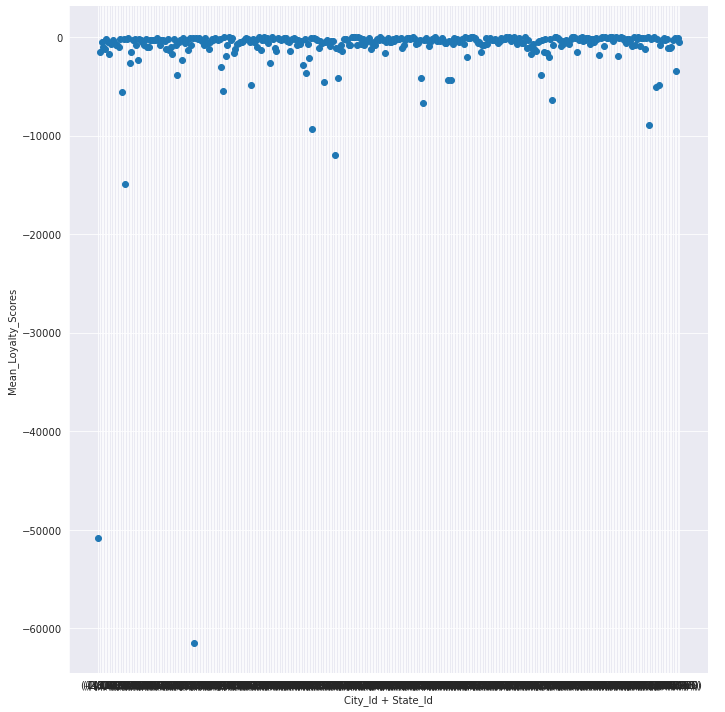

In [ ]:
sns.FacetGrid(data, size = 10)\
    .map(plt.scatter, 'City_Id + State_Id', 'Mean_Loyalty_Scores')\
    .add_legend()
plt.show()

- No such trend can be seen.

<h4> 3.2.3.4 Merchant Category Id </h4>

In [ ]:
mercCategoryIds = list(set(df_histTrans['merchant_category_id']))
mercCategoryIds.extend(list(set(df_newTrans['merchant_category_id'])))
print("No. of unique merchant category ids", len(list(set(mercCategoryIds))))

No. of unique merchant category ids 331


<h4> 3.2.3.5  Merchant Id </h4>

In [ ]:
mercids = list(set(df_histTrans['merchant_id']))
mercids.extend(list(set(df_newTrans['merchant_id'])))
print("No. of unique merchant ids", len(list(set(mercids))))

No. of unique merchant ids 334633


<h4> 3.2.3.6 Subsector Id </h4>

In [ ]:
subsectorids = list(set(df_histTrans['subsector_id']))
subsectorids.extend(list(set(df_newTrans['subsector_id'])))
print("No. of subsector ids", len(list(set(subsectorids))))

No. of subsector ids 41


<h4> 3.2.3.7 category_1</h4>

In [ ]:
category1 = list(set(df_histTrans['category_1']))
category1.extend(list(set(df_newTrans['category_1'])))
print("No. of unique category_1 values:", len(list(set(category1))))

No. of unique category_1 values: 2


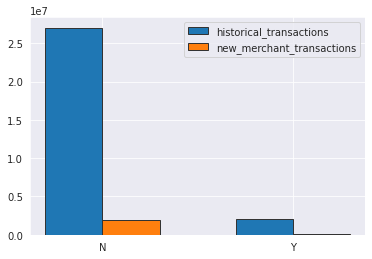

In [ ]:
x = np.array(['N', 'Y'])
plt.bar(x, [df_histTrans['category_1'].value_counts().values[0], df_histTrans['category_1'].value_counts().values[1]], width=-0.3, align='edge', label='historical_transactions', edgecolor=[0.2]*3)
plt.bar(x, [df_newTrans['category_1'].value_counts().values[0], df_newTrans['category_1'].value_counts().values[1]], width=0.3, align='edge', label='new_merchant_transactions', edgecolor=[0.2]*3)
plt.legend()
plt.show()

- Most of the values of category_1 is N.
- Both the categories are in same proportion in both the datasets.

In [ ]:
df_histTrans['category_1'] = df_histTrans['category_1'].apply(lambda x : 1 if x == 'Y' else 0)
df_newTrans['category_1'] = df_newTrans['category_1'].apply(lambda x : 1 if x == 'Y' else 0)

<h4> 3.2.3.8 category_2</h4>

In [ ]:
category2 = list(set(df_histTrans['category_2']))
category2.extend(list(set(df_newTrans['category_2'])))
print("No. of unique category_2 values:", len(list(set(category2))))

No. of unique category_2 values: 5


In [ ]:
df_newTrans['category_2'].value_counts()

1.0    1169987
3.0     289525
5.0     259266
4.0     178590
2.0      65663
Name: category_2, dtype: int64

In [ ]:
list1 = [df_histTrans['category_2'].value_counts().values[0], df_histTrans['category_2'].value_counts().values[1], df_histTrans['category_2'].value_counts().values[2]\
         ,df_histTrans['category_2'].value_counts().values[3],df_histTrans['category_2'].value_counts().values[4]] 

In [ ]:
list2 = [df_newTrans['category_2'].value_counts().values[0], df_newTrans['category_2'].value_counts().values[1], df_newTrans['category_2'].value_counts().values[2]\
         ,df_newTrans['category_2'].value_counts().values[3],df_newTrans['category_2'].value_counts().values[4]] 

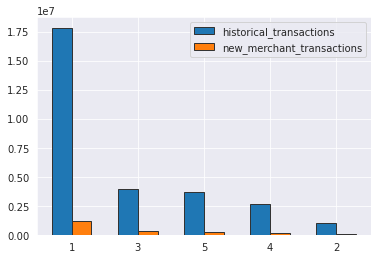

In [ ]:
x = np.array(['1', '3', '5', '4', '2'])
plt.bar(x, list1, width=-0.3, align='edge', label='historical_transactions', edgecolor=[0.2]*3)
plt.bar(x, list2, width=0.3, align='edge', label='new_merchant_transactions', edgecolor=[0.2]*3)
plt.legend()
plt.show()

- Most the values of category_2 is 1.0
- These categories seem to have been divided in the same proportion in both the transaction dataset.

<h4> 3.2.3.9 category_3</h4>

In [ ]:
category3 = list(set(df_histTrans['category_3']))
category3.extend(list(set(df_newTrans['category_3'])))
print("No. of unique category_3 values:", len(list(set(category3))))

No. of unique category_3 values: 3


In [ ]:
df_newTrans['category_3'].value_counts()

A    978166
B    836178
C    148687
Name: category_3, dtype: int64

In [ ]:
list1 = [df_histTrans['category_3'].value_counts().values[0], df_histTrans['category_3'].value_counts().values[1], df_histTrans['category_3'].value_counts().values[2]]
list2 = [df_newTrans['category_3'].value_counts().values[0], df_newTrans['category_3'].value_counts().values[1], df_newTrans['category_3'].value_counts().values[2]]

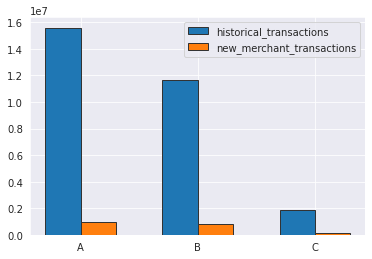

In [ ]:
x = np.array(['A', 'B', 'C'])
plt.bar(x, list1, width=-0.3, align='edge', label='historical_transactions', edgecolor=[0.2]*3)
plt.bar(x, list2, width=0.3, align='edge', label='new_merchant_transactions', edgecolor=[0.2]*3)
plt.legend()
plt.show()

- Most of the values of category_3 is A.

In [ ]:
dictOfCat = {'A' : 1, 'B': 2, 'C' : 3}
df_histTrans['category_3'] = df_histTrans['category_3'].apply(lambda x : dictOfCat[x])
df_newTrans['category_3'] = df_newTrans['category_3'].apply(lambda x : dictOfCat[x])

<h4> 3.2.3.10 Analysis on categorical variables category_1, category_2, category_3</h4>

In [ ]:
groupedCardIds = df_histTrans.groupby(['category_1', 'category_2', 'category_3'])['card_id'].apply(list)

In [ ]:
listOfLoyaltyScores = []
for i in range(len(groupedCardIds)):
    listOfAllUniqueIds = list(set(groupedCardIds.values[i]))
    sumOfLoyaltyScores = np.sum(df_train[df_train['card_id'].isin(listOfAllUniqueIds)]['target'])
    listOfLoyaltyScores.append(sumOfLoyaltyScores)

In [ ]:
listOfAllUniqueCombn = [str(groupedCardIds.keys()[i]) for i in range(len(groupedCardIds))]

In [ ]:
data = {'category_1 + category_2 + category_3': listOfAllUniqueCombn, 
        'Mean_Loyalty_Scores': listOfLoyaltyScores}
data = pd.DataFrame(data)

In [ ]:
data.value_counts()

category_1 + category_2 + category_3  Mean_Loyalty_Scores
(1, 1.0, 3)                           -30576.0               1
(1, 1.0, 2)                           -45344.0               1
(0, 1.0, 2)                           -51008.0               1
(0, 1.0, 3)                           -33888.0               1
(0, 2.0, 1)                           -3986.0                1
(0, 2.0, 2)                           -5348.0                1
(0, 2.0, 3)                           -2732.0                1
(0, 3.0, 1)                           -9864.0                1
(0, 3.0, 2)                           -13056.0               1
(0, 3.0, 3)                           -7480.0                1
(0, 4.0, 1)                           -6368.0                1
(0, 4.0, 2)                           -8488.0                1
(0, 4.0, 3)                           -5036.0                1
(0, 5.0, 1)                           -9872.0                1
(0, 5.0, 2)                           -14672.0              

- No such trend can be seen among the relation of these variables.

<h3> 3.2.4 Analysis on installment </h3>

In [ ]:
df_histTrans['installments'].value_counts()

 0      15411747
 1      11677522
 2        666416
 3        538207
 4        179525
-1        178159
 6        132634
 10       118827
 5        116090
 12        55064
 8         20474
 7         10906
 9          5772
 11          830
 999         188
Name: installments, dtype: int64

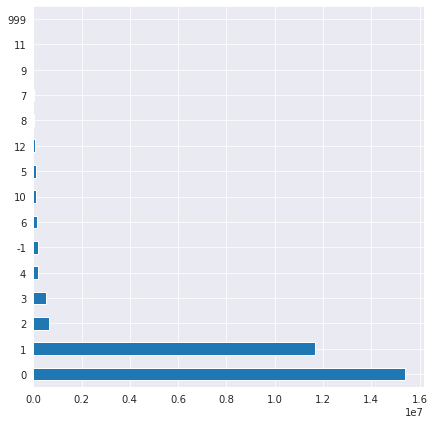

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (7,7))
df_histTrans['installments'].value_counts().plot(kind = 'barh')
plt.show()

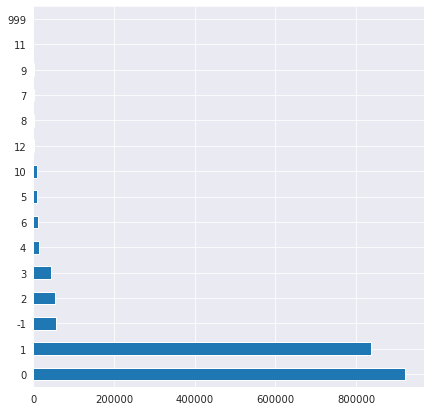

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (7,7))
df_newTrans['installments'].value_counts().plot(kind = 'barh')
plt.show()

- Most of the installments are 0 and 1.
- There are also installments having values -1 and 999.

<h4> 3.2.4.1 Analysing installments for -1 and 999 against authorized flag.

In [ ]:
temp_data_trans_auth = df_histTrans[['authorized_flag', 'installments']]

In [ ]:
allUnauthorizedTran = temp_data_trans_auth[(temp_data_trans_auth['installments'] == -1) | (temp_data_trans_auth['installments'] == 999) & (temp_data_trans_auth['authorized_flag'] == 0)]

In [ ]:
allTran = temp_data_trans_auth[(temp_data_trans_auth['installments'] == -1) | (temp_data_trans_auth['installments'] == 999)]

In [ ]:
print("Out of all transactions having installments -1 and 999 in historical_transactions", (allUnauthorizedTran.shape[0]/allTran.shape[0])*100 , "% is unauthorized.")

Out of all transactions having installments -1 and 999 in historical_transactions 99.99663577183804 % is unauthorized.


In [ ]:
temp_data_trans_install = df_newTrans.loc[(df_newTrans['installments'] == -1) | (df_newTrans['installments'] == 999),['installments']]

In [ ]:
print("Out of all transactions", (temp_data_trans_install.shape[0]/df_newTrans.shape[0])*100 , "% have installments -1 and 999.")

Out of all transactions 2.84885974801213 % have installments -1 and 999.


- As we can see in historical_transactions dataset, transactions having installment -1 and 999 have almost 99% of them are unauthorized.
- We know that in new_merchant_transactions dataset there are no unauthorized transactions. So out of them almost 3% of them were having installments -1 and 999, but they were all authorized.
- So these installments can mean anything.

<h4> 3.2.4.2 Analysing whether installments are useful against loyalty score </h4>

In [ ]:
installments = list(set(df_histTrans['installments']))
installments.extend(list(set(df_newTrans['installments'])))
print("No. of unique installments", len(list(set(installments))))

No. of unique installments 15


In [ ]:
temp_data_trans = reduce_mem_usage(df_histTrans[['card_id', 'installments']])
temp_data_train = reduce_mem_usage(df_train[['card_id', 'target']])

Mem. usage decreased to 277.64 Mb (0.0% reduction)
Mem. usage decreased to 13.47 Mb (0.0% reduction)


In [ ]:
df = reduce_mem_usage(pd.merge(temp_data_trans, temp_data_train, how='left', on='card_id'))

Mem. usage decreased to 555.27 Mb (0.0% reduction)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29112361 entries, 0 to 29112360
Data columns (total 3 columns):
 #   Column        Dtype  
---  ------        -----  
 0   card_id       object 
 1   installments  int16  
 2   target        float16
dtypes: float16(1), int16(1), object(1)
memory usage: 555.3+ MB


In [ ]:
#Randomly sampling some points, as there are huge no. of points.
df1 = df.sample(200000)

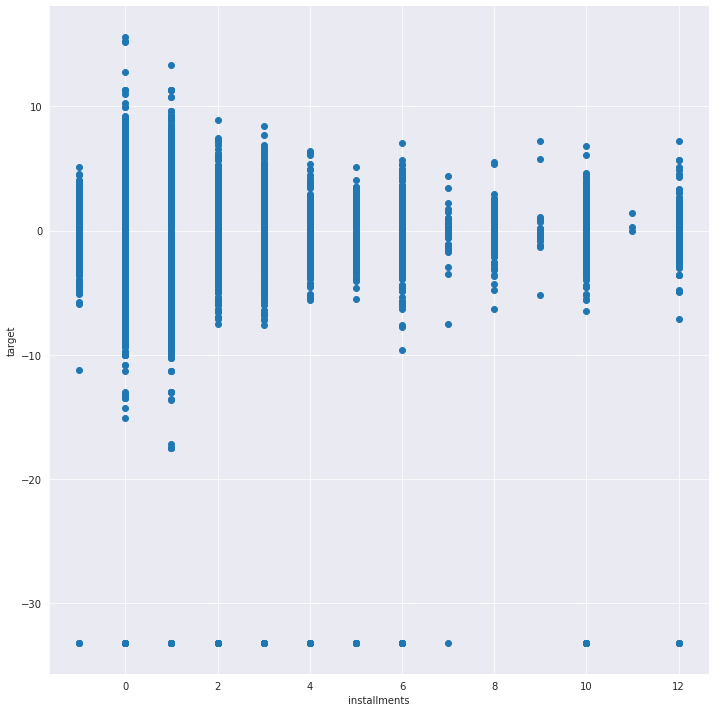

In [ ]:
sns.FacetGrid(df1, size = 10)\
    .map(plt.scatter, 'installments', 'target')\
    .add_legend()
plt.show()

- We can clearly see that loyalty scores are high for card ids having lower installements.
- This feature can be very useful while designing features as there is a clear trend.

<h3> 3.2.5 Analysis on purchase_amount </h3>

- Purchase amount is normalized as mentioned in DataDictionary of this problem.

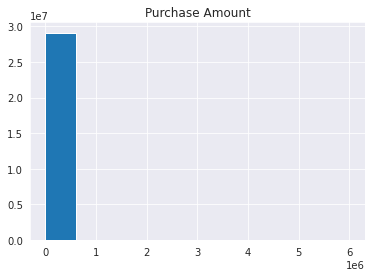

In [ ]:
plt.hist(df_histTrans['purchase_amount'], range = (df_histTrans['purchase_amount'].min(), df_histTrans['purchase_amount'].max()))
plt.title('Purchase Amount')
plt.show()

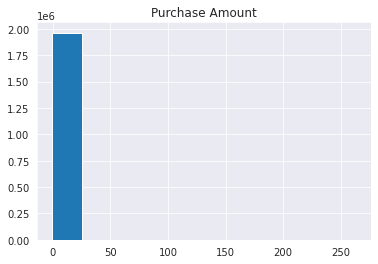

In [ ]:
plt.hist(df_newTrans['purchase_amount'], range = (df_newTrans['purchase_amount'].min(), df_newTrans['purchase_amount'].max()))
plt.title('Purchase Amount')
plt.show()

- As this feature is normalized. Nothing much can be said about this.

<h3> 3.2.6 Analysis on loyalty scores based on the frequency of transaction grouped by card ids. </h3>

In [ ]:
gc.collect()

360

In [ ]:
groupedCardIds = df_histTrans.groupby(['card_id'])['purchase_date'].apply(list)

In [ ]:
#https://stackoverflow.com/questions/18215317/extracting-days-from-a-numpy-timedelta64-value
listOfLoyaltyScores = []
listOfAllDifferencesMean = []
for i in tqdm(range(len(groupedCardIds))):
    try:
        #Some card ids don't exist in train dataset, but they exist in test dataset.
        loyaltyScore = (df_train[df_train['card_id'] == str(groupedCardIds.keys()[i])]['target']).values[0]
        listOfLoyaltyScores.append(loyaltyScore)
        allDays = 0
        for j in range(len(groupedCardIds.values[i]) - 1):
            #Taking the absolute difference of days between two transactions
            days = np.abs((groupedCardIds.values[i][j] - groupedCardIds.values[i][j + 1]).days)
            allDays += days  
        #Calculating the mean of all transaction time difference for a particular card id
        allDays = np.mean(np.array(allDays))
        listOfAllDifferencesMean.append(allDays)
    except:
        pass
 

100%|██████████| 325540/325540 [1:22:07<00:00, 66.06it/s]


In [ ]:
data = {'MeanDifferenceOfTransaction(days)': listOfAllDifferencesMean, 
        'Loyalty_Score': listOfLoyaltyScores}
data = pd.DataFrame(data)

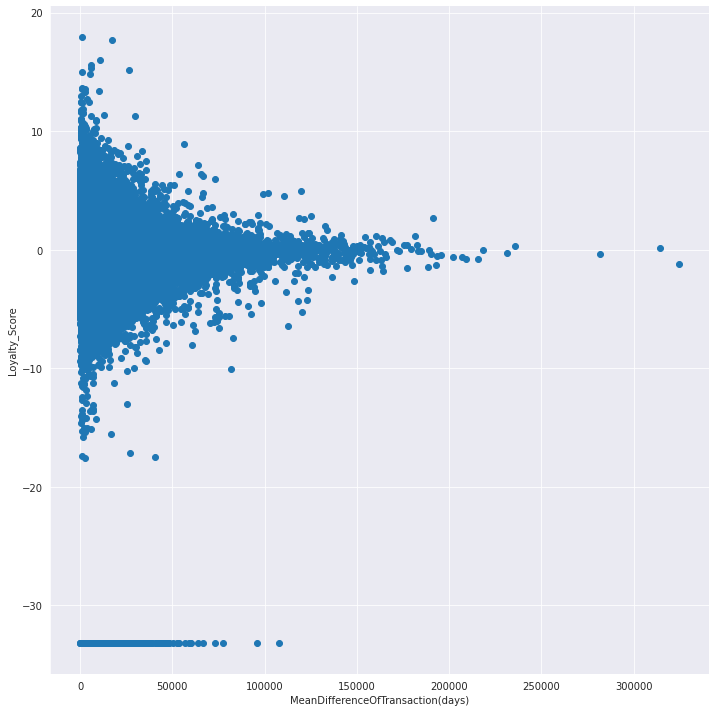

In [ ]:
sns.FacetGrid(data, size = 10)\
    .map(plt.scatter, 'MeanDifferenceOfTransaction(days)', 'Loyalty_Score')\
    .add_legend()
plt.show()

- Here we calculated the difference of days between transactions for a particular card id and took the mean of it.
- We can see that cards ids which are more frequent have higher loyalty scores also many of them have lower loyalty scores. 
- The outliers i.e. card ids having lowest loyalty scores have their differences mostly lower side.
- No such trend can be seen

In [ ]:
df_newTrans.to_csv("newTrans_EDA.csv", index= False)
df_histTrans.to_csv("histTrans_EDA.csv", index= False)

<h2> 3.3 Reading data from files merchants.csv and basic stats </h2>

In [ ]:
df_merchants = reduce_mem_usage(pd.read_csv("merchants.csv"))
print("No. of data points in merchants:", df_merchants.shape[0])

Mem. usage decreased to 30.32 Mb (46.0% reduction)
No. of data points in merchants: 334696


In [ ]:
df_merchants.head(5)

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057465,-0.057465,N,E,E,-0.400000,...,-2.250000,18.666667,6,-2.320000,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057465,-0.057465,N,E,E,-0.720000,...,-0.740000,1.291667,6,-0.570000,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057465,-0.057465,N,E,E,-82.129997,...,-82.129997,260.000000,2,-82.129997,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057465,-0.057465,Y,E,E,NaN,...,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057465,-0.057465,Y,E,E,NaN,...,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


In [ ]:
df_merchants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334696 entries, 0 to 334695
Data columns (total 22 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   merchant_id                  334696 non-null  object 
 1   merchant_group_id            334696 non-null  int32  
 2   merchant_category_id         334696 non-null  int16  
 3   subsector_id                 334696 non-null  int8   
 4   numerical_1                  334696 non-null  float16
 5   numerical_2                  334696 non-null  float16
 6   category_1                   334696 non-null  object 
 7   most_recent_sales_range      334696 non-null  object 
 8   most_recent_purchases_range  334696 non-null  object 
 9   avg_sales_lag3               334683 non-null  float32
 10  avg_purchases_lag3           334696 non-null  float64
 11  active_months_lag3           334696 non-null  int8   
 12  avg_sales_lag6               334683 non-null  float32
 13 

In [ ]:
gc.collect()

48

<h3> 3.3.1 Checking if there are any null values and replacing them </h3>

In [ ]:
print("Columns having null values in merchants", df_merchants.columns[df_merchants.isnull().any()].tolist())

Columns having null values in merchants ['avg_sales_lag3', 'avg_sales_lag6', 'avg_sales_lag12', 'category_2']


In [ ]:
print("Percentage of values rows having the null values")
print((df_merchants[df_merchants.columns[df_merchants.isnull().any()].tolist()].isnull().sum()/df_merchants.shape[0])*100)

Percentage of values rows having the null values
avg_sales_lag3     0.003884
avg_sales_lag6     0.003884
avg_sales_lag12    0.003884
category_2         3.551581
dtype: float64


- These 4 columns have nan values. We will replace this nan values with some valid alternative.
- There are only a very small % of missing values in all these rows except category_2. So we can safely remove the numerical values with the mean and the categorical ones with their modes.
- We will replace the missing values in category_2 with the unknown category that we created earlier.

In [ ]:
#avg_sales_lag3 numeric value will replace with mean
mean_avg_sales_lag3 = np.nanmean(df_merchants['avg_sales_lag3'])
print("Mean of avg_sales_lag3 after ignoring nan's:", mean_avg_sales_lag3)
df_merchants['avg_sales_lag3'] = df_merchants["avg_sales_lag3"].fillna(mean_avg_sales_lag3)

Mean of avg_sales_lag3 after ignoring nan's: 13.832988


In [ ]:
#avg_sales_lag6 numeric value will replace with mean
mean_avg_sales_lag6 = np.nanmean(df_merchants['avg_sales_lag6'])
print("Mean of avg_sales_lag6 after ignoring nan's:", mean_avg_sales_lag6)
df_merchants['avg_sales_lag6'] = df_merchants["avg_sales_lag6"].fillna(mean_avg_sales_lag6)

Mean of avg_sales_lag6 after ignoring nan's: 21.650787


In [ ]:
#avg_sales_lag12 numeric value will replace with mean
mean_avg_sales_lag12 = np.nanmean(df_merchants['avg_sales_lag12'])
print("Mean of avg_sales_lag12 after ignoring nan's: ", mean_avg_sales_lag12)
df_merchants['avg_sales_lag12'] = df_merchants["avg_sales_lag12"].fillna(mean_avg_sales_lag12)

Mean of avg_sales_lag12 after ignoring nan's:  25.227715


In [ ]:
#avg_sales_lag6 numeric value will replace with mean
mean_avg_sales_lag6 = np.nanmean(df_merchants['avg_sales_lag6'])
print("Mean of avg_sales_lag6 after ignoring: ", mean_avg_sales_lag6)
df_merchants['avg_sales_lag6'] = df_merchants["avg_sales_lag6"].fillna(mean_avg_sales_lag6)

Mean of avg_sales_lag6 after ignoring:  21.65079


In [ ]:
df_merchants['category_2'].value_counts()

1.0    160888
5.0     52923
3.0     51887
4.0     36450
2.0     20661
Name: category_2, dtype: int64

In [ ]:
#replacing category_2 with the value that we created values that we created earlier.
df_merchants['category_2'] = df_merchants["category_2"].fillna(unknown)

<h3> 3.3.2 Checking columns merchant_id, merchant_group_id, merchant_category_id </h3>

In [ ]:
print("No of unique merchant ids", df_merchants['merchant_id'].nunique())

No of unique merchant ids 334633


- There are 334696 rows in this table but only 334633 unique merchant ids.
- So we delete all the duplicate rows.

In [ ]:
merchant_cols = ['merchant_id']
df_merchants = df_merchants.drop_duplicates(subset = merchant_cols)

In [ ]:
df_merchants.shape

(334633, 22)

<h3> 3.3.2 Checking columns avg_purchases_lag3, avg_purchases_lag6, avg_purchases_lag12 </h3>

In [ ]:
print("avg_purchases_lag3,  max = ", df_merchants['avg_purchases_lag3'].max(), ", min= ", df_merchants['avg_purchases_lag3'].min())
print("avg_purchases_lag6,  max = ", df_merchants['avg_purchases_lag6'].max(), ", min= ", df_merchants['avg_purchases_lag6'].min())
print("avg_purchases_lag12, max = ", df_merchants['avg_purchases_lag12'].max(), ", min= ", df_merchants['avg_purchases_lag12'].min())

avg_purchases_lag3,  max =  inf , min=  0.33349533
avg_purchases_lag6,  max =  inf , min=  0.16704466
avg_purchases_lag12, max =  inf , min=  0.09832954


- These are columns containing inf values. We need to treat these.
- We will replace these values with the 2nd highest values from these columns.

In [ ]:
#https://www.geeksforgeeks.org/python-pandas-dataframe-nlargest/
df_merchants['avg_purchases_lag3'].nlargest()

10                inf
11                inf
12                inf
235      6.185133e+04
13168    1.730000e+03
Name: avg_purchases_lag3, dtype: float64

In [ ]:
df_merchants['avg_purchases_lag3'] = df_merchants['avg_purchases_lag3'].apply(lambda x : 6000 if x == np.inf else x)

In [ ]:
df_merchants['avg_purchases_lag6'].nlargest()

10              inf
11              inf
12              inf
235    5.607750e+04
15     3.432667e+03
Name: avg_purchases_lag6, dtype: float64

In [ ]:
df_merchants['avg_purchases_lag6'] = df_merchants['avg_purchases_lag6'].apply(lambda x : 5000 if x == np.inf else x)

In [ ]:
df_merchants['avg_purchases_lag12'].nlargest()

10              inf
11              inf
12              inf
235    5.021556e+04
15     5.236000e+03
Name: avg_purchases_lag12, dtype: float64

In [ ]:
df_merchants['avg_purchases_lag12'] = df_merchants['avg_purchases_lag12'].apply(lambda x : 5000 if x == np.inf else x)

<h3> 3.3.3 Analysis on columns numerical1 and numerical2 </h3>

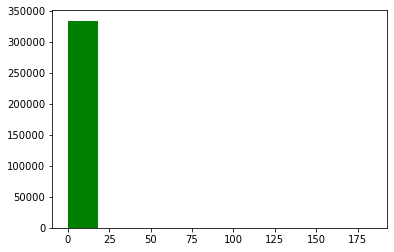

In [ ]:
plt.hist(df_merchants['numerical_1'], color='g')
plt.show()

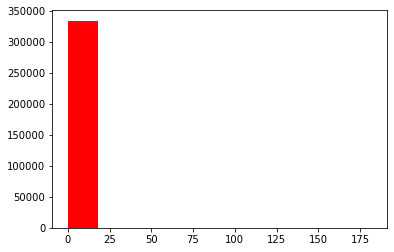

In [ ]:
plt.hist(df_merchants['numerical_2'], color='r')
plt.show()

- Both the numerical values seem to have same distribution.

<h3> 3.3.4 Analysis on columns most_recent_sales_range and most_recent_purchases_range </h3>

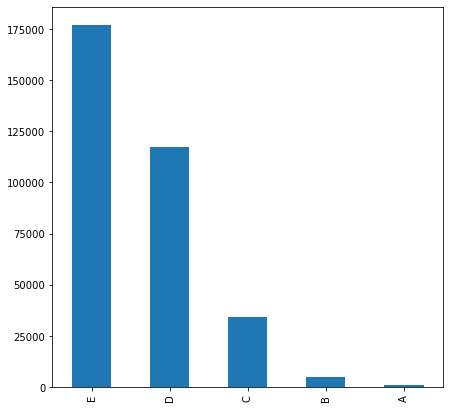

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (7,7))
df_merchants['most_recent_sales_range'].value_counts().plot(kind = 'bar')
plt.show()

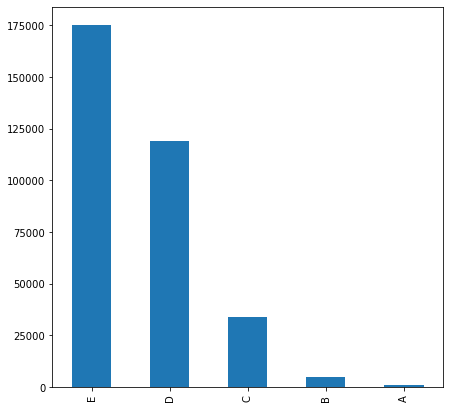

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (7,7))
df_merchants['most_recent_purchases_range'].value_counts().plot(kind = 'bar')
plt.show()

- These two distributions are almost similar.

<h3> 3.3.3 Checking other columns </h3>

In [ ]:
print("active_months_lag3,   max = ", df_merchants['active_months_lag3'].max(), ", min= ", df_merchants['active_months_lag3'].min())
print("active_months_lag6,   max = ", df_merchants['active_months_lag6'].max(), ", min= ", df_merchants['active_months_lag6'].min())
print("active_months_lag12,  max = ", df_merchants['active_months_lag12'].max(), ", min= ", df_merchants['active_months_lag12'].min())

active_months_lag3,   max =  3 , min=  1
active_months_lag6,   max =  6 , min=  1
active_months_lag12,  max =  12 , min=  1


In [ ]:
df_merchants['category_1'] = df_merchants['category_1'].apply(lambda x : 1 if x == 'Y' else 0)

In [ ]:
df_merchants['category_4'] = df_merchants['category_4'].apply(lambda x : 1 if x == 'Y' else 0)

In [ ]:
dictOfCat = {'A' : 1, 'B': 2, 'C' : 3, 'D' : 4 , 'E' : 5}
df_merchants['most_recent_sales_range'] = df_merchants['most_recent_sales_range'].apply(lambda x : dictOfCat[x])
df_merchants['most_recent_purchases_range'] = df_merchants['most_recent_purchases_range'].apply(lambda x : dictOfCat[x])

- There are many columns here representing the various sales and purchase data for various merchants. 
- We will need to see how much how many of them will be useful after plotting with respect to loyalty scores after aggregating data, which we will do in feature engineering part.

In [ ]:
df_merchants.to_csv("merchants_EDA.csv", index = False)

<h1>4. Feature Engineering <h1>

In [5]:
df_train = reduce_mem_usage(pd.read_csv("train_EDA.csv", parse_dates=['first_active_month']))
df_test = reduce_mem_usage(pd.read_csv("test_EDA.csv", parse_dates=['first_active_month']))
df_hist = reduce_mem_usage(pd.read_csv("histTrans_EDA.csv", parse_dates=['purchase_date']))
df_newTrans = reduce_mem_usage(pd.read_csv("newTrans_EDA.csv", parse_dates=['purchase_date']))
df_merchants = reduce_mem_usage(pd.read_csv("merchants_EDA.csv"))

Mem. usage decreased to  4.04 Mb (56.2% reduction)
Mem. usage decreased to  2.24 Mb (52.5% reduction)
Mem. usage decreased to 1166.08 Mb (62.5% reduction)
Mem. usage decreased to 74.88 Mb (64.3% reduction)
Mem. usage decreased to 15.64 Mb (72.2% reduction)


In [ ]:
gc.collect()

20

In [ ]:
nan_indexes = df_merchants[df_merchants.isna().any(1)]
print (nan_indexes)

Empty DataFrame
Columns: [merchant_id, merchant_group_id, merchant_category_id, subsector_id, numerical_1, numerical_2, category_1, most_recent_sales_range, most_recent_purchases_range, avg_sales_lag3, avg_purchases_lag3, active_months_lag3, avg_sales_lag6, avg_purchases_lag6, active_months_lag6, avg_sales_lag12, avg_purchases_lag12, active_months_lag12, category_4, city_id, state_id, category_2]
Index: []

[0 rows x 22 columns]


<h2>4.1 Extracting features from train.csv and test.csv </h2>

In [ ]:
#https://www.geeksforgeeks.org/python-pandas-series-dt-date/
def getFeaturesFromTrainAndTest(data):

    max_dte = data['first_active_month'].dt.date.max()

    #Time elapsed since first purchase
    data['time_elapsed'] = (max_dte - data['first_active_month'].dt.date).dt.days

    #Breaking first_active_month in year and month
    data['month'] = data['first_active_month'].dt.month
    data['year'] = data['first_active_month'].dt.year
    data['day'] = data['first_active_month'].dt.day

    return data

In [ ]:
df_train_FE = getFeaturesFromTrainAndTest(df_train)
df_test_FE = getFeaturesFromTrainAndTest(df_test)

In [ ]:
df_train_FE['is_rare'] = 0
df_train_FE.loc[df_train_FE['target'] < -30, 'is_rare'] = 1

In [ ]:
#mean_encoding based on whether the points are outliers are not
for f in ['feature_1','feature_2','feature_3']:
    mean_encoding = df_train_FE.groupby([f])['is_rare'].mean()
    df_train_FE[f] = df_train_FE[f].map(mean_encoding)
    df_test_FE[f] = df_test_FE[f].map(mean_encoding)

In [ ]:
columns_to_drop = ['first_active_month', 'is_rare']
df_train_FE = df_train_FE.drop(columns_to_drop, axis = 1)
columns_to_drop = ['first_active_month']
df_test_FE = df_test_FE.drop(columns_to_drop, axis = 1)

In [ ]:
df_train_FE.head(2)

,card_id,feature_1,feature_2,feature_3,target,time_elapsed,month,year,day
0,C_ID_f25b3d3f13,0.010479,0.011385,0.011428,0.645996,2284,11,2011,1
1,C_ID_2dbbc2b7fd,0.010479,0.014166,0.011428,-0.069580,2284,11,2011,1


In [ ]:
df_test_FE.head(2)

,card_id,feature_1,feature_2,feature_3,time_elapsed,month,year,day
0,C_ID_0ab67a22ab,0.010479,0.014166,0.011428,275,4,2017,1
1,C_ID_130fd0cbdd,0.010610,0.014166,0.010283,365,1,2017,1


<h2>4.2 Extracting features from historical_transactions.csv and new_merchants_transactions.csv </h2>

 - Here we will aggregate data from these two datasets grouping on card ids.

In [ ]:
df_hist['category_3'].value_counts()

1    15589906
2    11677522
3     1844933
Name: category_3, dtype: int64

In [ ]:
def std(x): 
    return np.std(x)

In [ ]:
import datetime

In [ ]:
#https://www.kaggle.com/artgor/elo-eda-and-models
def getFeaturesFromTransactionData(data, prefix):

    #Breaking purchase date into year,month, day
    data['purchase_year'] = data['purchase_date'].dt.year
    data['purchase_month'] = data['purchase_date'].dt.month
    data['purchase_day'] = data['purchase_date'].dt.day
    
    data['month_diff'] = ((datetime.datetime.today() - data['purchase_date']).dt.days)//30
    data['month_diff'] += data['month_lag']
    
    data['weekend'] = (data.purchase_date.dt.weekday >=5).astype(int)
    data['hour'] = data['purchase_date'].dt.hour
    
    #Converting category_2 and category_3 into indicator variables
    #https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html
    data = pd.get_dummies(data, columns=['category_2', 'category_3'])
    
    agg_func = {
        'authorized_flag': ['sum', 'mean'],
        'category_1': ['sum', 'mean'],
        'category_2_1.0': ['mean', 'sum'],
        'category_2_2.0': ['mean', 'sum'],
        'category_2_3.0': ['mean', 'sum'],
        'category_2_4.0': ['mean', 'sum'],
        'category_2_5.0': ['mean', 'sum'],
        'category_3_1': ['sum', 'mean'],
        'category_3_2': ['sum', 'mean'],
        'category_3_3': ['sum', 'mean'],
        'merchant_id': ['nunique'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', std],
        'installments': ['sum', 'mean', 'max', 'min', std],
        'purchase_month': ['mean', 'max', 'min', std],
        'purchase_year': ['mean', 'max', 'min', std],
        'purchase_day': ['mean', 'max', 'min', std],
        'month_lag': ['min', 'max'],
        'merchant_category_id': ['nunique'],
        'state_id': ['nunique'],
        'subsector_id': ['nunique'],
        'city_id': ['nunique'],
        'month_diff': ['min', 'max', 'mean']
    }
    agg_trans = data.groupby(['card_id']).agg(agg_func)
    agg_trans.columns = [prefix + '_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    df = (data.groupby('card_id')
          .size()
          .reset_index(name='{}transactions_count'.format(prefix)))

    agg_trans = pd.merge(df, agg_trans, on='card_id', how='left')

    return agg_trans

In [ ]:
%%time
gc.collect()
df_hist_FE = getFeaturesFromTransactionData(df_hist, prefix = 'hist_Trans_')

CPU times: user 3min 13s, sys: 2.46 s, total: 3min 15s
Wall time: 3min 14s


In [ ]:
%%time
gc.collect()
df_newTrans_FE = getFeaturesFromTransactionData(df_newTrans, prefix = 'new_Trans_')

CPU times: user 3min 21s, sys: 4.05 s, total: 3min 26s
Wall time: 3min 19s


In [ ]:
df_hist_FE.head(3).T

,0,1,2
card_id,C_ID_00007093c1,C_ID_0001238066,C_ID_0001506ef0
hist_Trans_transactions_count,149,123,66
hist_Trans_authorized_flag_sum,114,120,62
hist_Trans_authorized_flag_mean,0.765101,0.97561,0.939394
hist_Trans_category_1_sum,28,2,0
hist_Trans_category_1_mean,0.187919,0.0162602,0
hist_Trans_category_2_1.0_mean,0,0.772358,0.030303
hist_Trans_category_2_1.0_sum,0,95,2
hist_Trans_category_2_2.0_mean,0,0,0
hist_Trans_category_2_2.0_sum,0,0,0


In [ ]:
df_newTrans_FE.head(3).T

,0,1,2
card_id,C_ID_00007093c1,C_ID_0001238066,C_ID_0001506ef0
new_Trans_transactions_count,2,26,2
new_Trans_authorized_flag_sum,2,26,2
new_Trans_authorized_flag_mean,1,1,1
new_Trans_category_1_sum,0,2,0
new_Trans_category_1_mean,0,0.0769231,0
new_Trans_category_2_1.0_mean,0.5,0.769231,0
new_Trans_category_2_1.0_sum,1,20,0
new_Trans_category_2_2.0_mean,0,0,0
new_Trans_category_2_2.0_sum,0,0,0


In [ ]:
def aggregate_per_month(history):
    grouped = history.groupby(['card_id', 'month_lag'])
    history['installments'] = history['installments'].astype(int)
    agg_func = {
            'purchase_amount': ['count', 'sum', 'mean', 'min', 'max', std],
            'installments': ['count', 'sum', 'mean', 'min', 'max', std],
            }

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)

    final_group = intermediate_group.groupby('card_id').agg(['mean', std])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group

In [ ]:
%%time
gc.collect()
df_hist_month_FE = aggregate_per_month(df_hist)

CPU times: user 9min 12s, sys: 7.6 s, total: 9min 19s
Wall time: 9min 9s


In [ ]:
%%time
gc.collect()
df_newTrans_month_FE = aggregate_per_month(df_newTrans)

CPU times: user 8min 26s, sys: 4.12 s, total: 8min 30s
Wall time: 8min 23s


In [ ]:
df_hist_month_FE.head(2).T

,0,1
card_id,C_ID_00007093c1,C_ID_0001238066
month_lag_mean,-6,-2.5
month_lag_std,3.74166,1.70783
purchase_amount_count_mean,11.4615,20.5
purchase_amount_count_std,4.5169,11.2064
purchase_amount_sum_mean,-5.91116,-12.0745
purchase_amount_sum_std,2.65874,6.42109
purchase_amount_mean_mean,-0.507947,-0.603204
purchase_amount_mean_std,0.0934823,0.0418653
purchase_amount_min_mean,-0.704152,-0.730351


In [ ]:
df_newTrans_month_FE.head(2).T

,0,1
card_id,C_ID_00007093c1,C_ID_0001238066
month_lag_mean,2,1.5
month_lag_std,0,0.5
purchase_amount_count_mean,2,13
purchase_amount_count_std,0,4
purchase_amount_sum_mean,-1.32812,-7.42578
purchase_amount_sum_std,0,2.33203
purchase_amount_mean_mean,-0.664062,-0.569824
purchase_amount_mean_std,0,0.00390625
purchase_amount_min_mean,-0.671875,-0.729492


<h2>4.3 Extracting features from merchants.csv </h2>

- We will first concat all the transactions i.e. historical_transactions & new_merchant_transactions after that we will merge it the merchants dataset.
- We will then extract the merchants features from this dataset grouping on card id.

In [ ]:
df_merchants.head(2).T

,0,1
merchant_id,M_ID_838061e48c,M_ID_9339d880ad
merchant_group_id,8353,3184
merchant_category_id,792,840
subsector_id,9,20
numerical_1,-0.0574646,-0.0574646
numerical_2,-0.0574646,-0.0574646
category_1,0,0
most_recent_sales_range,5,5
most_recent_purchases_range,5,5
avg_sales_lag3,-0.4,-0.72


In [ ]:
allTransactions = pd.concat([df_hist, df_newTrans], axis = 0)

In [ ]:
allTransactions.shape

(31075392, 18)

In [ ]:
columns_to_drop = ['merchant_category_id', 'subsector_id', 'city_id', 'state_id', 'category_2', 'category_1']
allTransactions = allTransactions.drop(columns_to_drop, axis = 1)
df_merchants = df_merchants.drop(columns_to_drop, axis = 1)

In [ ]:
del df_hist, df_newTrans

In [ ]:
%%time
gc.collect()
df_merchants_trans = pd.merge(allTransactions, df_merchants, on='merchant_id', how='left')
del allTransactions

CPU times: user 15.1 s, sys: 1.17 s, total: 16.2 s
Wall time: 16.2 s


In [ ]:
def getFeaturesFromMerchantsData(data, prefix):
    
    data = pd.get_dummies(data, columns=['most_recent_sales_range', 'most_recent_purchases_range'])
    agg_func = {
        'merchant_group_id' : ['nunique'],
        'numerical_1' :['sum', 'mean', std],
        'numerical_2' :['sum', 'mean', std],
        'category_4' :['sum', 'mean', std],
        'most_recent_sales_range_1' :['sum', 'mean', std],
        'most_recent_sales_range_2' :['sum', 'mean', std],
        'most_recent_sales_range_3' :['sum', 'mean', std],
        'most_recent_sales_range_4' :['sum', 'mean', std],
        'most_recent_sales_range_5' :['sum', 'mean', std],
        'most_recent_purchases_range_1' :['sum', 'mean', std],
        'most_recent_purchases_range_2' :['sum', 'mean', std],
        'most_recent_purchases_range_3' :['sum', 'mean', std],
        'most_recent_purchases_range_4' :['sum', 'mean', std],
        'most_recent_purchases_range_5' :['sum', 'mean', std],
        'avg_sales_lag3' :['sum', 'mean', std],
        'avg_purchases_lag3' :['sum', 'mean', std],
        'active_months_lag3' :['sum', 'mean', std],
        'avg_sales_lag6' :['sum', 'mean', std],
        'avg_purchases_lag6' :['sum', 'mean', std],
        'active_months_lag6' :['sum', 'mean', std],
        'avg_sales_lag12' :['sum', 'mean', std],
        'avg_purchases_lag12' :['sum', 'mean', std],
        'active_months_lag12' :['sum', 'mean', std],
    }
    
    agg_trans = data.groupby(['card_id']).agg(agg_func)
    agg_trans.columns = [prefix + '_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    df = (data.groupby('card_id')
          .size()
          .reset_index(name='{}transactions_count'.format(prefix)))

    agg_trans = pd.merge(df, agg_trans, on='card_id', how='left')

    return agg_trans

In [ ]:
%%time
gc.collect()
df_merchants_FE = getFeaturesFromMerchantsData(df_merchants_trans, prefix = 'merchant_')
del df_merchants_trans

CPU times: user 16min 54s, sys: 7.1 s, total: 17min 1s
Wall time: 16min 55s


In [ ]:
df_merchants_FE.head(2).T

,0,1
card_id,C_ID_00007093c1,C_ID_0001238066
merchant_transactions_count,151,149
merchant_merchant_group_id_nunique,15,66
merchant_numerical_1_sum,270,1324
merchant_numerical_1_mean,1.78809,8.88281
...,...,...
merchant_avg_purchases_lag12_mean,1.21387,5.18359
merchant_avg_purchases_lag12_std,1.33398,inf
merchant_active_months_lag12_sum,1795,1775
merchant_active_months_lag12_mean,11.8874,11.9128


<h2>4.4 Merging all the data </h2>

In [ ]:
%%time
gc.collect()
train = pd.merge(df_train_FE, df_hist_FE, on='card_id',how='left')
train = pd.merge(train, df_newTrans_FE, on='card_id', how = 'left')
train = pd.merge(train, df_hist_month_FE, on = 'card_id', how = 'left')
train = pd.merge(train, df_newTrans_month_FE, on = 'card_id', how = 'left')
train = pd.merge(train, df_merchants_FE, on = 'card_id', how='left')

In [ ]:
%%time
gc.collect()
test = pd.merge(df_test_FE, df_hist_FE, on='card_id',how='left')
test = pd.merge(test, df_newTrans_FE, on='card_id', how = 'left')
test = pd.merge(test, df_hist_month_FE, on = 'card_id', how = 'left')
test = pd.merge(test, df_newTrans_month_FE, on = 'card_id', how = 'left')
#test = pd.merge(test, df_merchants_FE, on = 'card_id', how='left')

CPU times: user 2.52 s, sys: 0 ns, total: 2.52 s
Wall time: 2.51 s


In [ ]:
train.head()

,card_id,feature_1,feature_2,feature_3,target,time_elapsed,month,year,day,hist_Trans_transactions_count,...,merchant_active_months_lag6_std,merchant_avg_sales_lag12_sum,merchant_avg_sales_lag12_mean,merchant_avg_sales_lag12_std,merchant_avg_purchases_lag12_sum,merchant_avg_purchases_lag12_mean,merchant_avg_purchases_lag12_std,merchant_active_months_lag12_sum,merchant_active_months_lag12_mean,merchant_active_months_lag12_std
0,C_ID_f25b3d3f13,0.010479,0.011385,0.011428,0.645996,2284,11,2011,1,84,...,0.0,384.910004,4.324831,7.429107,497.5000,5.589844,8.632812,993.0,11.157303,1.871723
1,C_ID_2dbbc2b7fd,0.010479,0.014166,0.011428,-0.069580,2284,11,2011,1,30,...,0.0,39.410000,1.271290,0.246508,39.1875,1.263672,0.229370,372.0,12.000000,0.000000
2,C_ID_0a70866829,0.010479,0.011385,0.011428,-2.544922,2284,11,2011,1,72,...,0.0,302.459991,3.928052,18.792917,743.0000,9.648438,inf,889.0,11.545455,1.437399
3,C_ID_08cb8e0333,0.010479,0.014166,0.011428,-3.574219,2284,11,2011,1,46,...,0.0,213.990005,4.115192,11.583421,198.2500,3.812500,7.585938,589.0,11.326923,1.706561
4,C_ID_d26de4d1bf,0.010479,0.014166,0.011428,-0.693359,2284,11,2011,1,19,...,0.0,100.019997,5.264211,12.143413,68.3750,3.597656,7.628906,222.0,11.684211,0.920677


In [ ]:
test.head()

,card_id,feature_1,feature_2,feature_3,time_elapsed,month,year,day,hist_Trans_transactions_count,hist_Trans_authorized_flag_sum,...,merchant_active_months_lag6_std,merchant_avg_sales_lag12_sum,merchant_avg_sales_lag12_mean,merchant_avg_sales_lag12_std,merchant_avg_purchases_lag12_sum,merchant_avg_purchases_lag12_mean,merchant_avg_purchases_lag12_std,merchant_active_months_lag12_sum,merchant_active_months_lag12_mean,merchant_active_months_lag12_std
0,C_ID_0ab67a22ab,0.010479,0.014166,0.011428,275,4,2017,1,68,44.0,...,0.0,106.759995,1.503662,2.423732,117.125000,1.649414,3.136719,837.0,11.788732,1.005835
1,C_ID_130fd0cbdd,0.010610,0.014166,0.010283,365,1,2017,1,78,77.0,...,0.0,96.480003,1.108966,0.812490,108.437500,1.247070,1.654297,1035.0,11.896552,0.678648
2,C_ID_b709037bc5,0.013145,0.011385,0.011428,153,8,2017,1,13,9.0,...,0.0,14.820000,0.988000,0.248199,16.578125,1.104492,0.257812,180.0,12.000000,0.000000
3,C_ID_d27d835a9f,0.010610,0.011385,0.010283,31,12,2017,1,26,26.0,...,0.0,36.970001,1.026944,0.136988,38.500000,1.069336,0.134521,432.0,12.000000,0.000000
4,C_ID_2b5e3df5c2,0.013145,0.011385,0.011428,762,12,2015,1,110,87.0,...,0.0,343.670013,2.962672,10.934388,333.250000,2.873047,9.382812,1350.0,11.637931,1.248424


In [ ]:
del df_test_FE, df_train_FE, df_newTrans_FE, df_merchants_FE, df_hist_FE

In [ ]:
train.replace([-np.inf,np.inf], np.nan, inplace=True)
test.replace([-np.inf,np.inf], np.nan, inplace=True)

In [ ]:
train['new_Trans_transactions_count'].fillna(train['new_Trans_transactions_count'].mode()[0], inplace=True)
train['new_Trans_authorized_flag_sum'].fillna(train['new_Trans_authorized_flag_sum'].mode()[0], inplace=True)
train['new_Trans_authorized_flag_mean'].fillna(train['new_Trans_authorized_flag_mean'].mode()[0], inplace=True)
train['new_Trans_category_1_sum'].fillna(train['new_Trans_category_1_sum'].mode()[0], inplace=True)
train['new_Trans_category_1_mean'].fillna(train['new_Trans_category_1_mean'].mode()[0], inplace=True)
train['new_Trans_category_2_1.0_mean'].fillna(train['new_Trans_category_2_1.0_mean'].mode()[0], inplace=True)
train['new_Trans_category_2_1.0_sum'].fillna(train['new_Trans_category_2_1.0_sum'].mode()[0], inplace=True)
train['new_Trans_category_2_2.0_mean'].fillna(train['new_Trans_category_2_2.0_mean'].mode()[0], inplace=True)
train['new_Trans_category_2_2.0_sum'].fillna(train['new_Trans_category_2_2.0_sum'].mode()[0], inplace=True)
train['new_Trans_category_2_3.0_mean'].fillna(train['new_Trans_category_2_3.0_mean'].mode()[0], inplace=True)
train['new_Trans_category_2_3.0_sum'].fillna(train['new_Trans_category_2_3.0_sum'].mode()[0], inplace=True)
train['new_Trans_category_2_4.0_mean'].fillna(train['new_Trans_category_2_4.0_mean'].mode()[0], inplace=True)
train['new_Trans_category_2_4.0_sum'].fillna(train['new_Trans_category_2_4.0_sum'].mode()[0], inplace=True)
train['new_Trans_category_2_5.0_sum'].fillna(train['new_Trans_category_2_5.0_sum'].mode()[0], inplace=True)
train['new_Trans_category_2_5.0_mean'].fillna(train['new_Trans_category_2_5.0_mean'].mode()[0], inplace=True)
train['new_Trans_category_3_1_sum'].fillna(train['new_Trans_category_3_1_sum'].mode()[0], inplace=True)
train['new_Trans_category_3_1_mean'].fillna(train['new_Trans_category_3_1_mean'].mode()[0], inplace=True)
train['new_Trans_category_3_2_sum'].fillna(train['new_Trans_category_3_2_sum'].mode()[0], inplace=True)
train['new_Trans_category_3_2_mean'].fillna(train['new_Trans_category_3_2_mean'].mode()[0], inplace=True)
train['new_Trans_category_3_3_sum'].fillna(train['new_Trans_category_3_3_sum'].mode()[0], inplace=True)
train['new_Trans_category_3_3_mean'].fillna(train['new_Trans_category_3_3_mean'].mode()[0], inplace=True)
train['new_Trans_merchant_id_nunique'].fillna(train['new_Trans_merchant_id_nunique'].mode()[0], inplace=True)
train['new_Trans_purchase_amount_sum'].fillna(train['new_Trans_purchase_amount_sum'].mode()[0], inplace=True)
train['new_Trans_purchase_amount_mean'].fillna(train['new_Trans_purchase_amount_mean'].mode()[0], inplace=True)
train['new_Trans_purchase_amount_max'].fillna(train['new_Trans_purchase_amount_max'].mode()[0], inplace=True)
train['new_Trans_purchase_amount_min'].fillna(train['new_Trans_purchase_amount_min'].mode()[0], inplace=True)
train['new_Trans_purchase_amount_std'].fillna(train['new_Trans_purchase_amount_std'].mode()[0], inplace=True)
train['new_Trans_installments_sum'].fillna(train['new_Trans_installments_sum'].mode()[0], inplace=True)
train['new_Trans_installments_mean'].fillna(train['new_Trans_installments_mean'].mode()[0], inplace=True)
train['new_Trans_installments_max'].fillna(train['new_Trans_installments_max'].mode()[0], inplace=True)
train['new_Trans_installments_min'].fillna(train['new_Trans_installments_min'].mode()[0], inplace=True)
train['new_Trans_installments_std'].fillna(train['new_Trans_installments_std'].mode()[0], inplace=True)
train['new_Trans_purchase_month_mean'].fillna(train['new_Trans_purchase_month_mean'].mode()[0], inplace=True)
train['new_Trans_purchase_month_max'].fillna(train['new_Trans_purchase_month_max'].mode()[0], inplace=True)
train['new_Trans_purchase_month_min'].fillna(train['new_Trans_purchase_month_min'].mode()[0], inplace=True)
train['new_Trans_purchase_month_std'].fillna(train['new_Trans_purchase_month_std'].mode()[0], inplace=True)
train['new_Trans_purchase_year_mean'].fillna(train['new_Trans_purchase_year_mean'].mode()[0], inplace=True)
train['new_Trans_purchase_year_max'].fillna(train['new_Trans_purchase_year_max'].mode()[0], inplace=True)
train['new_Trans_purchase_year_min'].fillna(train['new_Trans_purchase_year_min'].mode()[0], inplace=True)
train['new_Trans_purchase_year_std'].fillna(train['new_Trans_purchase_year_std'].mode()[0], inplace=True)
train['new_Trans_purchase_day_mean'].fillna(train['new_Trans_purchase_day_mean'].mode()[0], inplace=True)
train['new_Trans_purchase_day_max'].fillna(train['new_Trans_purchase_day_max'].mode()[0], inplace=True)
train['new_Trans_purchase_day_min'].fillna(train['new_Trans_purchase_day_min'].mode()[0], inplace=True)
train['new_Trans_purchase_day_std'].fillna(train['new_Trans_purchase_day_std'].mode()[0], inplace=True)
train['new_Trans_month_lag_min'].fillna(train['new_Trans_month_lag_min'].mode()[0], inplace=True)
train['new_Trans_month_lag_max'].fillna(train['new_Trans_month_lag_max'].mode()[0], inplace=True)
train['new_Trans_merchant_category_id_nunique'].fillna(train['new_Trans_merchant_category_id_nunique'].mode()[0], inplace=True)
train['new_Trans_state_id_nunique'].fillna(train['new_Trans_state_id_nunique'].mode()[0], inplace=True)
train['new_Trans_subsector_id_nunique'].fillna(train['new_Trans_subsector_id_nunique'].mode()[0], inplace=True)
train['new_Trans_city_id_nunique'].fillna(train['new_Trans_city_id_nunique'].mode()[0], inplace=True)
train['merchant_avg_purchases_lag3_sum'].fillna(train['merchant_avg_purchases_lag3_sum'].mode()[0], inplace=True)
train['merchant_avg_purchases_lag3_std'].fillna(train['merchant_avg_purchases_lag3_std'].mode()[0], inplace=True)
train['merchant_avg_purchases_lag6_sum'].fillna(train['merchant_avg_purchases_lag6_sum'].mode()[0], inplace=True)
train['merchant_avg_purchases_lag6_std'].fillna(train['merchant_avg_purchases_lag6_std'].mode()[0], inplace=True)
train['merchant_avg_purchases_lag12_sum'].fillna(train['merchant_avg_purchases_lag12_sum'].mode()[0], inplace=True)
train['merchant_avg_purchases_lag12_std'].fillna(train['merchant_avg_purchases_lag12_std'].mode()[0], inplace=True)
train['new_Trans_month_diff_min'].fillna(train['new_Trans_month_diff_min'].mode()[0], inplace=True)
train['new_Trans_month_diff_max'].fillna(train['new_Trans_month_diff_max'].mode()[0], inplace=True)
train['new_Trans_month_diff_mean'].fillna(train['new_Trans_month_diff_mean'].mode()[0], inplace=True)



train['month_lag_mean_y'].fillna(train['month_lag_mean_y'].mode()[0], inplace=True)
train['month_lag_std_y'].fillna(train['month_lag_std_y'].mode()[0], inplace=True)
train['purchase_amount_count_mean_y'].fillna(train['purchase_amount_count_mean_y'].mode()[0], inplace=True)
train['purchase_amount_count_std_y'].fillna(train['purchase_amount_count_std_y'].mode()[0], inplace=True)
train['purchase_amount_sum_mean_y'].fillna(train['purchase_amount_sum_mean_y'].mode()[0], inplace=True)
train['purchase_amount_sum_std_y'].fillna(train['purchase_amount_sum_std_y'].mode()[0], inplace=True)
train['purchase_amount_mean_mean_y'].fillna(train['purchase_amount_mean_mean_y'].mode()[0], inplace=True)
train['purchase_amount_mean_std_y'].fillna(train['purchase_amount_mean_std_y'].mode()[0], inplace=True)
train['purchase_amount_min_mean_y'].fillna(train['purchase_amount_min_mean_y'].mode()[0], inplace=True)


train['purchase_amount_min_std_y'].fillna(train['purchase_amount_min_std_y'].mode()[0], inplace=True)
train['purchase_amount_max_mean_y'].fillna(train['purchase_amount_max_mean_y'].mode()[0], inplace=True)
train['purchase_amount_max_std_y'].fillna(train['purchase_amount_max_std_y'].mode()[0], inplace=True)
train['purchase_amount_std_mean_y'].fillna(train['purchase_amount_std_mean_y'].mode()[0], inplace=True)
train['purchase_amount_sum_mean_y'].fillna(train['purchase_amount_sum_mean_y'].mode()[0], inplace=True)
train['purchase_amount_std_std_y'].fillna(train['purchase_amount_std_std_y'].mode()[0], inplace=True)
train['installments_count_mean_y'].fillna(train['installments_count_mean_y'].mode()[0], inplace=True)
train['installments_count_std_y'].fillna(train['installments_count_std_y'].mode()[0], inplace=True)
train['installments_sum_mean_y'].fillna(train['installments_sum_mean_y'].mode()[0], inplace=True)


train['installments_sum_std_y'].fillna(train['installments_sum_std_y'].mode()[0], inplace=True)
train['installments_mean_mean_y'].fillna(train['installments_mean_mean_y'].mode()[0], inplace=True)
train['installments_mean_std_y'].fillna(train['installments_mean_std_y'].mode()[0], inplace=True)
train['installments_min_mean_y'].fillna(train['installments_min_mean_y'].mode()[0], inplace=True)
train['installments_min_std_y'].fillna(train['installments_min_std_y'].mode()[0], inplace=True)
train['installments_max_mean_y'].fillna(train['installments_max_mean_y'].mode()[0], inplace=True)
train['installments_max_std_y'].fillna(train['installments_max_std_y'].mode()[0], inplace=True)
train['installments_std_mean_y'].fillna(train['installments_std_mean_y'].mode()[0], inplace=True)
train['installments_std_std_y'].fillna(train['installments_std_std_y'].mode()[0], inplace=True)

In [ ]:
train.columns[train.isna().any()]

Index([], dtype='object')

In [ ]:
test['new_Trans_transactions_count'].fillna(test['new_Trans_transactions_count'].mode()[0], inplace=True)
test['new_Trans_authorized_flag_sum'].fillna(test['new_Trans_authorized_flag_sum'].mode()[0], inplace=True)
test['new_Trans_authorized_flag_mean'].fillna(test['new_Trans_authorized_flag_mean'].mode()[0], inplace=True)
test['new_Trans_category_1_sum'].fillna(test['new_Trans_category_1_sum'].mode()[0], inplace=True)
test['new_Trans_category_1_mean'].fillna(test['new_Trans_category_1_mean'].mode()[0], inplace=True)
test['new_Trans_category_2_1.0_mean'].fillna(test['new_Trans_category_2_1.0_mean'].mode()[0], inplace=True)
test['new_Trans_category_2_1.0_sum'].fillna(test['new_Trans_category_2_1.0_sum'].mode()[0], inplace=True)
test['new_Trans_category_2_2.0_mean'].fillna(test['new_Trans_category_2_2.0_mean'].mode()[0], inplace=True)
test['new_Trans_category_2_2.0_sum'].fillna(test['new_Trans_category_2_2.0_sum'].mode()[0], inplace=True)
test['new_Trans_category_2_3.0_mean'].fillna(test['new_Trans_category_2_3.0_mean'].mode()[0], inplace=True)
test['new_Trans_category_2_3.0_sum'].fillna(test['new_Trans_category_2_3.0_sum'].mode()[0], inplace=True)
test['new_Trans_category_2_4.0_mean'].fillna(test['new_Trans_category_2_4.0_mean'].mode()[0], inplace=True)
test['new_Trans_category_2_4.0_sum'].fillna(test['new_Trans_category_2_4.0_sum'].mode()[0], inplace=True)
test['new_Trans_category_2_5.0_sum'].fillna(test['new_Trans_category_2_5.0_sum'].mode()[0], inplace=True)
test['new_Trans_category_2_5.0_mean'].fillna(test['new_Trans_category_2_5.0_mean'].mode()[0], inplace=True)
test['new_Trans_category_3_1_sum'].fillna(test['new_Trans_category_3_1_sum'].mode()[0], inplace=True)
test['new_Trans_category_3_1_mean'].fillna(test['new_Trans_category_3_1_mean'].mode()[0], inplace=True)
test['new_Trans_category_3_2_sum'].fillna(test['new_Trans_category_3_2_sum'].mode()[0], inplace=True)
test['new_Trans_category_3_2_mean'].fillna(test['new_Trans_category_3_2_mean'].mode()[0], inplace=True)
test['new_Trans_category_3_3_sum'].fillna(test['new_Trans_category_3_3_sum'].mode()[0], inplace=True)
test['new_Trans_category_3_3_mean'].fillna(test['new_Trans_category_3_3_mean'].mode()[0], inplace=True)
test['new_Trans_merchant_id_nunique'].fillna(test['new_Trans_merchant_id_nunique'].mode()[0], inplace=True)
test['new_Trans_purchase_amount_sum'].fillna(test['new_Trans_purchase_amount_sum'].mode()[0], inplace=True)
test['new_Trans_purchase_amount_mean'].fillna(test['new_Trans_purchase_amount_mean'].mode()[0], inplace=True)
test['new_Trans_purchase_amount_max'].fillna(test['new_Trans_purchase_amount_max'].mode()[0], inplace=True)
test['new_Trans_purchase_amount_min'].fillna(test['new_Trans_purchase_amount_min'].mode()[0], inplace=True)
test['new_Trans_purchase_amount_std'].fillna(test['new_Trans_purchase_amount_std'].mode()[0], inplace=True)
test['new_Trans_installments_sum'].fillna(test['new_Trans_installments_sum'].mode()[0], inplace=True)
test['new_Trans_installments_mean'].fillna(test['new_Trans_installments_mean'].mode()[0], inplace=True)
test['new_Trans_installments_max'].fillna(test['new_Trans_installments_max'].mode()[0], inplace=True)
test['new_Trans_installments_min'].fillna(test['new_Trans_installments_min'].mode()[0], inplace=True)
test['new_Trans_installments_std'].fillna(test['new_Trans_installments_std'].mode()[0], inplace=True)
test['new_Trans_purchase_month_mean'].fillna(test['new_Trans_purchase_month_mean'].mode()[0], inplace=True)
test['new_Trans_purchase_month_max'].fillna(test['new_Trans_purchase_month_max'].mode()[0], inplace=True)
test['new_Trans_purchase_month_min'].fillna(test['new_Trans_purchase_month_min'].mode()[0], inplace=True)
test['new_Trans_purchase_month_std'].fillna(test['new_Trans_purchase_month_std'].mode()[0], inplace=True)
test['new_Trans_purchase_year_mean'].fillna(test['new_Trans_purchase_year_mean'].mode()[0], inplace=True)
test['new_Trans_purchase_year_max'].fillna(test['new_Trans_purchase_year_max'].mode()[0], inplace=True)
test['new_Trans_purchase_year_min'].fillna(test['new_Trans_purchase_year_min'].mode()[0], inplace=True)
test['new_Trans_purchase_year_std'].fillna(test['new_Trans_purchase_year_std'].mode()[0], inplace=True)
test['new_Trans_purchase_day_mean'].fillna(test['new_Trans_purchase_day_mean'].mode()[0], inplace=True)
test['new_Trans_purchase_day_max'].fillna(test['new_Trans_purchase_day_max'].mode()[0], inplace=True)
test['new_Trans_purchase_day_min'].fillna(test['new_Trans_purchase_day_min'].mode()[0], inplace=True)
test['new_Trans_purchase_day_std'].fillna(test['new_Trans_purchase_day_std'].mode()[0], inplace=True)
test['new_Trans_month_lag_min'].fillna(test['new_Trans_month_lag_min'].mode()[0], inplace=True)
test['new_Trans_month_lag_max'].fillna(test['new_Trans_month_lag_max'].mode()[0], inplace=True)
test['new_Trans_merchant_category_id_nunique'].fillna(test['new_Trans_merchant_category_id_nunique'].mode()[0], inplace=True)
test['new_Trans_state_id_nunique'].fillna(test['new_Trans_state_id_nunique'].mode()[0], inplace=True)
test['new_Trans_subsector_id_nunique'].fillna(test['new_Trans_subsector_id_nunique'].mode()[0], inplace=True)
test['new_Trans_city_id_nunique'].fillna(test['new_Trans_city_id_nunique'].mode()[0], inplace=True)
test['merchant_avg_purchases_lag3_sum'].fillna(test['merchant_avg_purchases_lag3_sum'].mode()[0], inplace=True)
test['merchant_avg_purchases_lag3_std'].fillna(test['merchant_avg_purchases_lag3_std'].mode()[0], inplace=True)
test['merchant_avg_purchases_lag6_sum'].fillna(test['merchant_avg_purchases_lag6_sum'].mode()[0], inplace=True)
test['merchant_avg_purchases_lag6_std'].fillna(test['merchant_avg_purchases_lag6_std'].mode()[0], inplace=True)
test['merchant_avg_purchases_lag12_sum'].fillna(test['merchant_avg_purchases_lag12_sum'].mode()[0], inplace=True)
test['merchant_avg_purchases_lag12_std'].fillna(test['merchant_avg_purchases_lag12_std'].mode()[0], inplace=True)
test['new_Trans_month_diff_min'].fillna(test['new_Trans_month_diff_min'].mode()[0], inplace=True)
test['new_Trans_month_diff_max'].fillna(test['new_Trans_month_diff_max'].mode()[0], inplace=True)
test['new_Trans_month_diff_mean'].fillna(test['new_Trans_month_diff_mean'].mode()[0], inplace=True)

test['month_lag_mean_y'].fillna(test['month_lag_mean_y'].mode()[0], inplace=True)
test['month_lag_std_y'].fillna(test['month_lag_std_y'].mode()[0], inplace=True)
test['purchase_amount_count_mean_y'].fillna(test['purchase_amount_count_mean_y'].mode()[0], inplace=True)
test['purchase_amount_count_std_y'].fillna(test['purchase_amount_count_std_y'].mode()[0], inplace=True)
test['purchase_amount_sum_mean_y'].fillna(test['purchase_amount_sum_mean_y'].mode()[0], inplace=True)
test['purchase_amount_sum_std_y'].fillna(test['purchase_amount_sum_std_y'].mode()[0], inplace=True)
test['purchase_amount_mean_mean_y'].fillna(test['purchase_amount_mean_mean_y'].mode()[0], inplace=True)
test['purchase_amount_mean_std_y'].fillna(test['purchase_amount_mean_std_y'].mode()[0], inplace=True)
test['purchase_amount_min_mean_y'].fillna(test['purchase_amount_min_mean_y'].mode()[0], inplace=True)


test['purchase_amount_min_std_y'].fillna(test['purchase_amount_min_std_y'].mode()[0], inplace=True)
test['purchase_amount_max_mean_y'].fillna(test['purchase_amount_max_mean_y'].mode()[0], inplace=True)
test['purchase_amount_max_std_y'].fillna(test['purchase_amount_max_std_y'].mode()[0], inplace=True)
test['purchase_amount_std_mean_y'].fillna(test['purchase_amount_std_mean_y'].mode()[0], inplace=True)
test['purchase_amount_sum_mean_y'].fillna(test['purchase_amount_sum_mean_y'].mode()[0], inplace=True)
test['purchase_amount_std_std_y'].fillna(test['purchase_amount_std_std_y'].mode()[0], inplace=True)
test['installments_count_mean_y'].fillna(test['installments_count_mean_y'].mode()[0], inplace=True)
test['installments_count_std_y'].fillna(test['installments_count_std_y'].mode()[0], inplace=True)
test['installments_sum_mean_y'].fillna(test['installments_sum_mean_y'].mode()[0], inplace=True)


test['installments_sum_std_y'].fillna(test['installments_sum_std_y'].mode()[0], inplace=True)
test['installments_mean_mean_y'].fillna(test['installments_mean_mean_y'].mode()[0], inplace=True)
test['installments_mean_std_y'].fillna(test['installments_mean_std_y'].mode()[0], inplace=True)
test['installments_min_mean_y'].fillna(test['installments_min_mean_y'].mode()[0], inplace=True)
test['installments_min_std_y'].fillna(test['installments_min_std_y'].mode()[0], inplace=True)
test['installments_max_mean_y'].fillna(test['installments_max_mean_y'].mode()[0], inplace=True)
test['installments_max_std_y'].fillna(test['installments_max_std_y'].mode()[0], inplace=True)
test['installments_std_mean_y'].fillna(test['installments_std_mean_y'].mode()[0], inplace=True)
test['installments_std_std_y'].fillna(test['installments_std_std_y'].mode()[0], inplace=True)

In [ ]:
test.columns[test.isna().any()]

Index([], dtype='object')

In [ ]:
train.to_csv("final_train.csv",index = False)
test.to_csv("final_test.csv",index = False)

In [19]:
train = reduce_mem_usage(pd.read_csv("final_train.csv"))
test = reduce_mem_usage(pd.read_csv("final_test.csv"))

Mem. usage decreased to 96.86 Mb (73.2% reduction)
Mem. usage decreased to 56.94 Mb (74.2% reduction)


<h1>5. Models <h1>

<h2>5.1 Regression Models </h2>

In [18]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgbm
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.metrics import mean_squared_error
import time
import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn.linear_model import BayesianRidge
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss

In [5]:
y = train['target']
X = train.drop(['target', 'card_id'], axis = 1)

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [7]:
X.head(2)

,feature_1,feature_2,feature_3,time_elapsed,month,year,day,hist_Trans_transactions_count,hist_Trans_authorized_flag_sum,hist_Trans_authorized_flag_mean,...,merchant_active_months_lag6_std,merchant_avg_sales_lag12_sum,merchant_avg_sales_lag12_mean,merchant_avg_sales_lag12_std,merchant_avg_purchases_lag12_sum,merchant_avg_purchases_lag12_mean,merchant_avg_purchases_lag12_std,merchant_active_months_lag12_sum,merchant_active_months_lag12_mean,merchant_active_months_lag12_std
0,0.010483,0.011383,0.011429,2284,11,2011,1,84,59.0,0.702148,...,0.0,384.910004,4.324831,7.429107,497.5000,5.589844,8.632812,993.0,11.15625,1.87207
1,0.010483,0.014168,0.011429,2284,11,2011,1,30,27.0,0.899902,...,0.0,39.410000,1.271290,0.246508,39.1875,1.263672,0.229370,372.0,12.00000,0.00000


<h3>5.1.1 Linear Regression </h3>

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_val)
X_train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
X_test_rmse = np.sqrt(mean_squared_error(y_val, y_pred_test))
print("Train RMSE: ", X_train_rmse)
print("Test RMSE: ",X_test_rmse)

Train RMSE:  3.8179185
Test RMSE:  3.7208004


<h3>5.1.2 SGD Regression </h3>

In [ ]:
alpha = [0.0000001, 0.000001,  0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 100000]
max_iter = [10, 100, 1000]
params = {'alpha' : alpha,
          'max_iter' : max_iter}

model = SGDRegressor()
gridsearch = GridSearchCV(model, params, scoring = 'neg_root_mean_squared_error', cv = 5)
gridsearch.fit(X_train, y_train)
gridsearch.best_params_

{'alpha': 1000, 'max_iter': 100}

In [ ]:
model = SGDRegressor(alpha= 1000, max_iter=100)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_val)

train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_val, y_pred_test))

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

Train RMSE: 1.3328120569632663e+20
Test RMSE: 1.0005355719208283e+20


- This model is performing horribly.

<h3>5.1.3 LGBM </h3>

In [15]:
clf = lgbm.LGBMRegressor(n_jobs = -1, verbose = 1)

params = {
            'num_leaves': [30, 50, 100, 150, 200, 250],
            'n_estimators': [100, 500, 1000, 1500, 2000, 2500, 3000, 3500],
            'colsample_bytree' : [0.1, 0.4, 0.6, 0.8, 1.0, 1.2],
            'learning_rate': [0.0001 ,0.001, 0.01, 0.1],
            'max_depth': [4, 6, 8, 10, 12],
}

grid_search = RandomizedSearchCV(clf, params, scoring = 'neg_root_mean_squared_error', cv = 5)
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'colsample_bytree': 0.6,
 'learning_rate': 0.01,
 'max_depth': 10,
 'n_estimators': 500,
 'num_leaves': 250}

In [16]:
model = lgbm.LGBMRegressor(n_jobs=-1, 
                      num_leaves = 250,
                      n_estimators = 500,
                      max_depth = 10,
                      learning_rate = 0.01,
                      colsample_bytree = 0.6)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_val)

train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_val, y_pred_test))

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

Train RMSE: 3.0823249903264083
Test RMSE: 3.599007090538773


In [17]:
test_CardId = test['card_id']
test_Data = test.drop(['card_id'], axis = 1)

In [18]:
test_pred = model.predict(test_Data)

In [19]:
data = {'card_id' : list(test_CardId),
        'target' : list(test_pred)
}
data = pd.DataFrame(data)

In [20]:
data.head(2)

,card_id,target
0,C_ID_0ab67a22ab,-4.842349
1,C_ID_130fd0cbdd,-0.378474


In [21]:
data.to_csv("test_submission.csv", index= False)

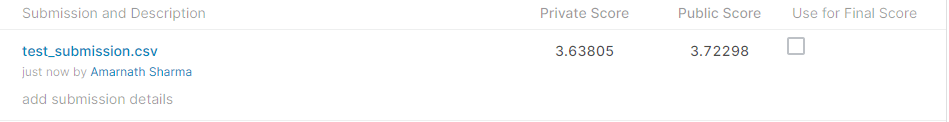

<h3>5.1.4 LGBM with KFold</h3>

In [ ]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

In [ ]:
train_RMSE_list = []
val_RMSE_list = []
for fold, (X_train_index, X_val_index) in enumerate(folds.split(X)):
    print("Fold :", fold, "started at", time.ctime())
    X_train, X_val = X.iloc[X_train_index], X.iloc[X_val_index]
    y_train, y_val = y.iloc[X_train_index], y.iloc[X_val_index]

    #https://www.kaggle.com/artgor/elo-eda-and-models
    params = {'num_leaves': 54,
         'min_data_in_leaf': 79,
         'objective': 'regression',
         'max_depth': 18,
         'learning_rate': 0.018545526395058548,
         "boosting": "gbdt",
         "feature_fraction": 0.8354507676881442,
         "bagging_freq": 5,
         "bagging_fraction": 0.8126672064208567,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         'min_child_weight': 5.343384366323818,
         'reg_alpha': 1.1302650970728192,
         'reg_lambda': 0.3603427518866501,
         'subsample': 0.8767547959893627,}

    model = lgbm.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
    model.fit(X_train, y_train, eval_set = (X_val, y_val), eval_metric = 'rmse', verbose = 1000, early_stopping_rounds = 200)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_val)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_val, y_pred_test))

    train_RMSE_list.append(train_rmse)
    val_RMSE_list.append(test_rmse)


    print("Train RMSE:", train_rmse)
    print("Test RMSE:", test_rmse)

Fold : 0 started at Thu Jan 28 07:29:20 2021
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] bagging_fraction is set=0.8126672064208567, subsample=0.8767547959893627 will be ignored. Current value: bagging_fraction=0.8126672064208567
[LightGBM] [Warning] feature_fraction is set=0.8354507676881442, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8354507676881442
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=1.1302650970728192 will be ignored. Current value: lambda_l1=0.1
Training until validation scores don't improve for 200 rounds
Early st

In [ ]:
test_CardId = test['card_id']
test_Data = test.drop(['card_id'], axis = 1)

In [ ]:
test_pred = model.predict(test_Data)

In [ ]:
data = {'card_id' : list(test_CardId),
        'target' : list(test_pred)
}
data = pd.DataFrame(data)

In [ ]:
data.head(2)

,card_id,target
0,C_ID_0ab67a22ab,-4.119254
1,C_ID_130fd0cbdd,-0.079001


In [ ]:
data.to_csv("test_submission.csv", index= False)

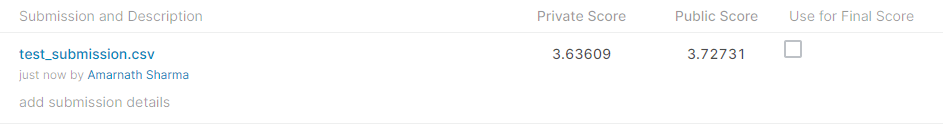

<h3>5.1.5 XgBoost with KFold </h3>

In [ ]:
train_RMSE_list = []
val_RMSE_list = []
for fold, (X_train_index, X_val_index) in enumerate(folds.split(X)):
    print("Fold :", fold, "started at", time.ctime())
    X_train, X_val = X.iloc[X_train_index], X.iloc[X_val_index]
    y_train, y_val = y.iloc[X_train_index], y.iloc[X_val_index]
    xgb_params = {'n_estimators' : 3000, 'max_depth': 8,  'learning_rate': 0.001, 'colsample_bytree': 0.8, 
          'num_leaves' : 250, 'eval_metric': 'rmse', 'nthread': 4}

    train_data = xgb.DMatrix(data=X_train, label=y_train)
    valid_data = xgb.DMatrix(data=X_val, label=y_val)

    watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
    model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=xgb_params)

    y_pred_train = model.predict(xgb.DMatrix(X_train), ntree_limit=model.best_ntree_limit)
    y_pred_valid = model.predict(xgb.DMatrix(X_val), ntree_limit=model.best_ntree_limit)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_val, y_pred_valid))

    train_RMSE_list.append(train_rmse)
    val_RMSE_list.append(test_rmse)


    print("Train RMSE: {:2.5f}".format(train_rmse))
    print("Test RMSE: {:2.5f}".format(test_rmse))

Fold : 0 started at Sat Jan 23 04:57:41 2021
[0]	train-rmse:3.97032	valid_data-rmse:3.87872
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:3.72696	valid_data-rmse:3.72955
[1000]	train-rmse:3.5861	valid_data-rmse:3.67003
[1500]	train-rmse:3.49308	valid_data-rmse:3.64443
[2000]	train-rmse:3.42054	valid_data-rmse:3.63252
[2500]	train-rmse:3.36084	valid_data-rmse:3.62626
[3000]	train-rmse:3.31241	valid_data-rmse:3.62292
[3500]	train-rmse:3.27438	valid_data-rmse:3.62153
[4000]	train-rmse:3.24317	valid_data-rmse:3.62067
[4500]	train-rmse:3.21997	valid_data-rmse:3.62008
[5000]	train-rmse:3.20235	valid_data-rmse:3.61957
[5500]	train-rmse:3.18664	valid_data-rmse:3.61911
[6000]	train-rmse:3.17072	valid_data-rmse:3.61902
Stopping. Best iteration:
[5866]	train-rmse:3.17482	valid_data-rmse:3.61899

Train RMSE: 3.17482
Test RMSE: 3.61899
Fold : 1 started at Sat Jan 23 06:18:1

In [ ]:
test_CardId = test['card_id']
test_Data = test.drop(['card_id'], axis = 1)

In [ ]:
test_pred = model.predict(xgb.DMatrix(test_Data), ntree_limit=model.best_ntree_limit)

In [ ]:
data = {'card_id' : list(test_CardId),
        'target' : list(test_pred)
}
data = pd.DataFrame(data)

In [ ]:
data.head(2)

,card_id,target
0,C_ID_0ab67a22ab,-4.372157
1,C_ID_130fd0cbdd,-0.710922


In [ ]:
data.to_csv("test_submission.csv", index= False)

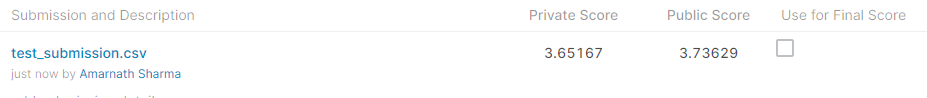

<h3>5.1.6 Ada Boost </h3>

In [ ]:
n_estimators = [50, 100, 150, 200, 250, 500, 1000, 2000, 3000, 5000, 10000, 20000, 25000]
params = {'n_estimators' : n_estimators}

model = AdaBoostRegressor()
gridsearch = GridSearchCV(model, params, scoring = 'neg_root_mean_squared_error', cv = 5)
gridsearch.fit(X_train, y_train)
gridsearch.best_params_

{'n_estimators': 500}

In [ ]:
model = AdaBoostRegressor(n_estimators= 500)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_val)

train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_val, y_pred_test))

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

Train RMSE: 5.746392606541428
Test RMSE: 5.712749233803937


<h3>5.1.7 Custom Model </h3>

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, random_state = 42)

In [10]:
import random
from random import seed
from random import randrange


def generateRandomData(Indices, k):
    '''
        This method takes a list of indices and selects k of them randomly
    '''
    distinctData = set()
    N = len(Indices)
    while len(distinctData) < k:
        p = randrange(0,N)
        distinctData.add(Indices[p])
    return list(distinctData)

In [11]:
#https://stackoverflow.com/questions/22927181/selecting-specific-rows-and-columns-from-numpy-array
def generating_samples(input_data, target_data):
    '''
        This method takes input and output data and selects data from them randomly with replacement.
    '''
    listOfRowIndices = [x for x in range(len(input_data))]
    iniSampleSize = int(0.6*len(input_data))
    Selecting_rows = generateRandomData(listOfRowIndices, iniSampleSize)   
    replicateSampleSize = [x for x in range(len(Selecting_rows))]
    Replacing_rows = generateRandomData(replicateSampleSize, len(input_data) - len(Selecting_rows))
    Selecting_rows = np.array(Selecting_rows)
    sample_data = input_data.iloc[Selecting_rows]
    target_of_sample_data = target_data.iloc[Selecting_rows]
    Replicated_sample_data = sample_data.iloc[Replacing_rows]
    target_of_Replicated_sample_data = target_data.iloc[Replacing_rows]
    final_sample_data = np.vstack((sample_data, Replicated_sample_data))
    final_target_data = np.vstack((np.array(target_of_sample_data).reshape(-1,1), np.array(target_of_Replicated_sample_data).reshape(-1,1)))
    return list(final_sample_data), list(final_target_data)

In [12]:
# Use generating_samples function to create k samples
# store these created samples in a list
def CreateKSamples(x , y, n_estimator):
    list_input_data =[]
    list_output_data =[]
    for i in tqdm(range(n_estimator)):
        a,b = generating_samples(x, y)
        list_input_data.append(a)
        list_output_data.append(b)
    gc.collect()
    return list_input_data, list_output_data

In [13]:
from sklearn.tree import DecisionTreeRegressor

def CreateAlistofAllModels(list_input_data, list_output_data, n_estimator):
    listofAllModels = []
    for i in tqdm(range(n_estimator)):
        model = DecisionTreeRegressor()
        model.fit(list_input_data[i], list_output_data[i])
        listofAllModels.append(model)
    gc.collect()
    return listofAllModels

In [14]:
def CreateDataSetPredictions(listofAllModels, X_val, n_estimator):
    data = {}
    for i in tqdm(range(n_estimator)):
        propertyName = 'pred_' + str(i+1)
        data[propertyName] = list(listofAllModels[i].predict(X_val)) 
    gc.collect()
    return data

In [15]:
def CustomModel1(X_train, y_train, X_val, y_val, n_estimator):

    list_input_data ,list_output_data = CreateKSamples(X_train , y_train, n_estimator)

    BaseModels = CreateAlistofAllModels(list_input_data, list_output_data, n_estimator)

    dictOfData = CreateDataSetPredictions(BaseModels, X_val, n_estimator)

    pred_df = pd.DataFrame(dictOfData)


    meta_model = lgbm.LGBMRegressor(n_jobs=-1, 
                      num_leaves = 250,
                      n_estimators = 1000,
                      max_depth = 8,
                      learning_rate = 0.001,
                      colsample_bytree = 0.6)
    meta_model.fit(pred_df, y_val)


    y_pred_test = meta_model.predict(pred_df)

    test_rmse = np.sqrt(mean_squared_error(y_val, y_pred_test))

    print("Test RMSE:", test_rmse)

    return BaseModels, meta_model

In [17]:
BaseModels, meta_model = CustomModel1(X_train, y_train, X_val, y_val, 100)

100%|██████████| 100/100 [00:10<00:00,  9.52it/s]


Test RMSE: 3.6275384053762


In [18]:
test_CardId = test['card_id']
test_Data = test.drop(['card_id'], axis = 1)

In [19]:
dictOfData = CreateDataSetPredictions(BaseModels, test_Data, 100)

100%|██████████| 100/100 [00:25<00:00,  3.93it/s]


In [20]:
pred_df = pd.DataFrame(dictOfData)

In [21]:
test_pred = meta_model.predict(pred_df)

In [22]:
data = {'card_id' : list(test_CardId),
        'target' : list(test_pred)
}
data = pd.DataFrame(data)

In [23]:
data.head(2)

,card_id,target
0,C_ID_0ab67a22ab,-0.702288
1,C_ID_130fd0cbdd,-0.494178


In [24]:
data.to_csv("test_submission.csv", index= False)

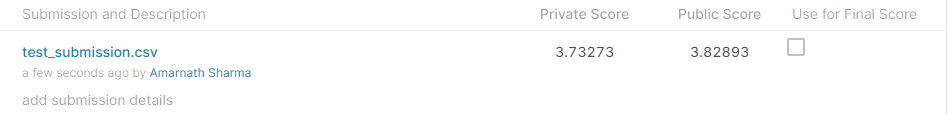

<h3>5.1.8 LGBM with Stratified Fold based on outliers points </h3>

In [20]:
df_train = train
df_test = test

In [21]:
df_train['outliers'] = 0
df_train.loc[df_train['target'] < -30, 'outliers'] = 1
df_train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [22]:
df_train_columns = [c for c in df_train.columns if c not in ['card_id', 'first_active_month','target','outliers']]
target = df_train['target']
del df_train['target']

In [23]:
import joblib

In [24]:
param = {'num_leaves': 54,
         'min_data_in_leaf': 79, 
         'objective':'regression',
         'max_depth': 18,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgbm.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])
    val_data = lgbm.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgbm.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 3.64195	valid_1's rmse: 3.72968
[200]	training's rmse: 3.54988	valid_1's rmse: 3.70597
[300]	training's rmse: 3.49292	valid_1's rmse: 3.69756
[400]	training's rmse: 3.45103	valid_1's rmse: 3.69359
[500]	training's rmse: 3.41617	valid_1's rmse: 3.6927
[600]	training's rmse: 3.3846	valid_1's rmse: 3.69167
[700]	training's rmse: 3.35677	valid_1's rmse: 3.69129
[800]	training's rmse: 3.32971	valid_1's rmse: 3.69123
Early stopping, best iteration is:
[754]	training's rmse: 3.34234	valid_1's rmse: 3.69081
fold 1
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 3.64334	valid_1's rmse: 3.72352
[200]	training's rmse: 3.55086	vali

3.6683961203879645

In [25]:
#saving the model
joblib.dump(clf,'finalModel.pkl')

['finalModel.pkl']

In [ ]:
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submission.csv", index=False)

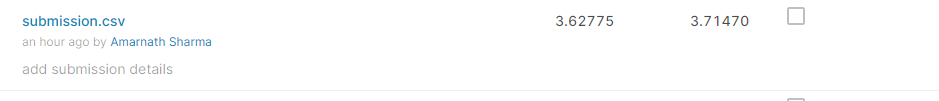

<h2>5.2 Classification Models </h3>

- We will try to convert this to a binary classification problem
- We have to ignore test dataset as we dont have correct classes.(We can try incorporate that based on the predictions that we make from regression task)
- Our two classes being Loyal(1) and Not Loyal(0)
- We will first standardize the target column, 'Loyal' if target >= 0 else 'NotLoyal'

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

In [6]:
scaler = StandardScaler().fit(np.array(train['target']).reshape(-1,1))

In [7]:
train['target'] = scaler.transform(np.array(train['target']).reshape(-1,1))

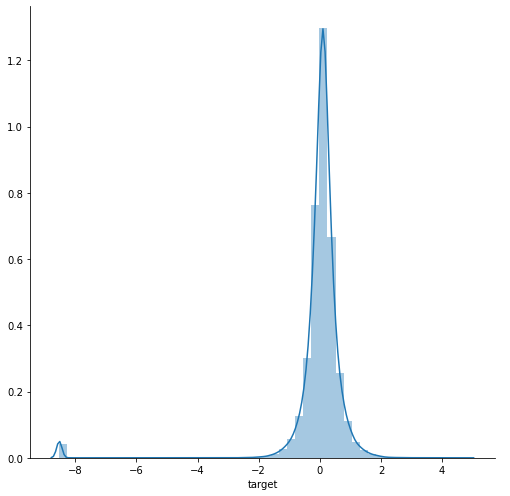

In [8]:
sns.FacetGrid(train, size = 7)\
    .map(sns.distplot, 'target')\
    .add_legend()
plt.show()

- target data is normalized as we can see from the above plot

In [9]:
train['target'] = train['target'].apply(lambda x : 1 if x >= 0 else 0)

In [10]:
train['target'].value_counts()

1    126335
0     75582
Name: target, dtype: int64

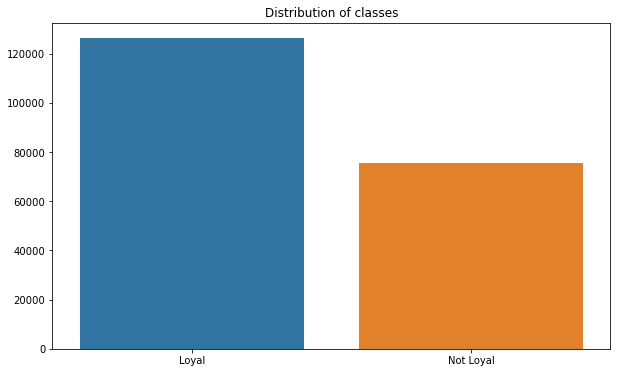

In [11]:
x = ["Loyal" , "Not Loyal"]
y =  [train['target'].value_counts()[1] , train['target'].value_counts()[0]]

plt.figure(figsize=(10, 6))
plt.title ("Distribution of classes")
sns.barplot(x,y)
plt.show()

- For metric we can go for 
 - Log loss 
 - Binary Confusion Matrix

In [12]:
y = train['target']
X = train.drop(['target', 'card_id'], axis = 1)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

<h3>5.2.1 Logistic Regression with hyperparameter tuning </h3>

In [14]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

For values of alpha =  0.01 The log loss is: 0.6598125880584119
For values of alpha =  0.1 The log loss is: 0.6598125880584119
For values of alpha =  1 The log loss is: 0.6598125880584119
For values of alpha =  10 The log loss is: 0.6598125880584119
For values of alpha =  100 The log loss is: 0.6598184414982601
For values of alpha =  1000 The log loss is: 0.6598137840608809
For values of alpha =  10000 The log loss is: 0.6598281396234847


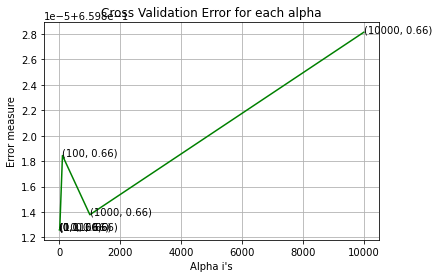

For values of best alpha =  0.01 The train log loss is: 0.6613721452356421
For values of best alpha =  0.01 The test log loss is: 0.6598125880584119
Total number of data points : 20192


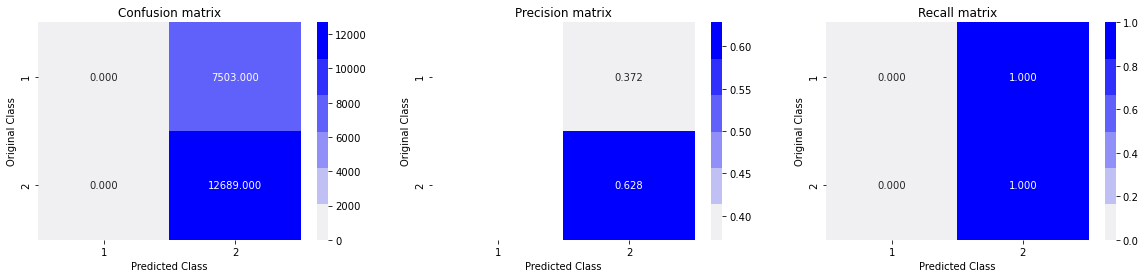

Macro f1_score = 0.7718135093214927


In [16]:
alpha = [10 ** x for x in range(-2, 5)] 

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)
print("Macro f1_score = {}".format(f1_score(y_test, predicted_y)))


<h3>5.2.2 XgBoost </h3>

[0]	train-logloss:0.68852	valid-logloss:0.69163
[10]	train-logloss:0.64698	valid-logloss:0.67791
[20]	train-logloss:0.61018	valid-logloss:0.66693
[30]	train-logloss:0.57701	valid-logloss:0.65778
[40]	train-logloss:0.54675	valid-logloss:0.64995
[50]	train-logloss:0.51972	valid-logloss:0.64345
[60]	train-logloss:0.49470	valid-logloss:0.63807
[70]	train-logloss:0.47199	valid-logloss:0.63375
[80]	train-logloss:0.45106	valid-logloss:0.63014
[90]	train-logloss:0.43153	valid-logloss:0.62712
[100]	train-logloss:0.41321	valid-logloss:0.62432
[110]	train-logloss:0.39635	valid-logloss:0.62204
[120]	train-logloss:0.38056	valid-logloss:0.62018
[130]	train-logloss:0.36591	valid-logloss:0.61867
[140]	train-logloss:0.35275	valid-logloss:0.61723
[150]	train-logloss:0.34051	valid-logloss:0.61616
[160]	train-logloss:0.32895	valid-logloss:0.61531
[170]	train-logloss:0.31816	valid-logloss:0.61474
[180]	train-logloss:0.30810	valid-logloss:0.61408
[190]	train-logloss:0.29896	valid-logloss:0.61339
[200]	train

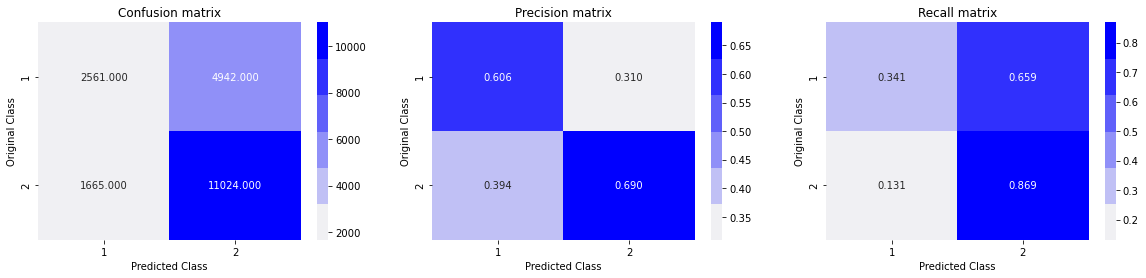

Macro f1_score = 0.7694294189495724


In [17]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.01
params['max_depth'] = 18

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)
print("Macro f1_score = {}".format(f1_score(y_test, predicted_y)))